In [114]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from copy import deepcopy as copy
from disp import get_ordered_colors
from functools import partial

plt.rc('font', family='serif')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2.0


## Computational approach

Easiest thing to do is just to simulate this probably. Can I graph the flow in 2D for just E$\rightarrow$E homeostasis vs for both types?

In [ ]:
T = 0.4 # Total duration of one network simulation
dt = 1e-4 # Timestep
t = np.linspace(0, T, int(T / dt))

def calc_alpha_func(tau_alpha):
    alpha_func_n_steps = int(10 * tau_alpha / dt)
    t_alpha = np.arange(0, alpha_func_n_steps) * dt
    return np.e * t_alpha / tau_alpha * np.exp(-t_alpha/tau_alpha)

def calc_response(inp, w, b, tau):
    r = np.zeros_like(t)
    s = np.zeros_like(t)

    for i in range(0, len(t) - 1):
        s[i+1] = s[i] + (w * inp[i] - s[i]) * dt / tau # update synaptic conductance as exponential filter of input
        r[i+1] = np.max([s[i+1] - b, 0])
    return r

w_0 = 1
b_0 = 0.1
tau = 5e-3
n_cycles = 200
w_set = 6e-7
b_set = 0.015
colors = get_ordered_colors('coolwarm', n_cycles)

trajs = np.zeros((100, (n_cycles + 1) * 3))
weight_trajs = np.zeros((100, (n_cycles + 1) * 2))

idx = 0
for tau_alpha in np.linspace(1e-3, 20e-3, 10):
    for a in np.linspace(0.01, 1, 10):
        r = np.zeros_like(t)
        w = copy(w_0)
        b = copy(b_0)
        
        inp = np.zeros_like(t)
        a_prime = a + np.random.normal(scale=0 * a)
        tau_alpha_prime = tau_alpha + np.random.normal(scale=0 * tau_alpha)
        inp_alpha = a_prime * calc_alpha_func(tau_alpha_prime)
        inp[:len(inp_alpha)] = inp_alpha
        
        m1_in = np.sum(inp * t) / np.sum(inp)
        
        traj = [tau_alpha, a, 0]
        weight_traj = [w, b]
        
        r_peak = a
        
        for i_cycle in range(n_cycles):
            r = calc_response(inp, w, b, tau)
        #     print(np.sum(np.square(r)) * dt)
            w += (100000 * (w_set - np.sum(np.square(r)) * np.square(dt)))
            b += (2 * (np.sum(r) * dt - b_set))
            if w <= 0:
                w = 1e-8
            if b <= 0:
                b = 1e-8
                
            r_peak = np.max(r)
            m0 = np.sum(r) * dt
            m1_out = np.sum(r * t) * dt
            if m0 > 0:
                m1_out /= m0
        
            tau_out = 0
            if r_peak > 0:
                tau_out = m0 / r_peak
            traj.append(tau_out) 
            traj.append(r_peak)
            traj.append(m1_out)
            weight_traj.append(w)
            weight_traj.append(b)
        trajs[idx, :] = np.array(traj)
        weight_trajs[idx, :] = np.array(weight_traj)
        idx += 1
        

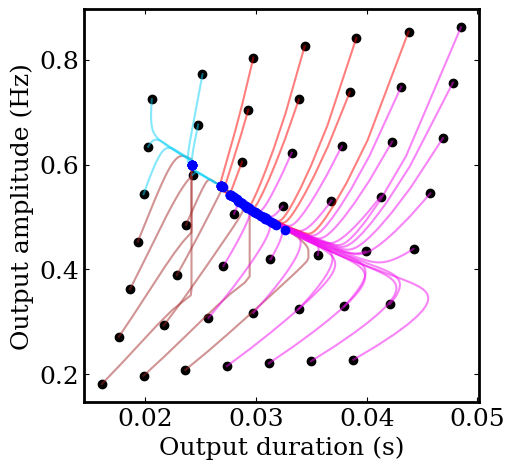

In [57]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    weight_traj = weight_trajs[i_traj, :]
    
    x_idxs = np.arange(3, len(traj), 3)
    y_idxs = np.arange(4, len(traj), 3)
    w_diff = weight_traj[-2] - weight_traj[0]
    b_diff = weight_traj[-1] - weight_traj[1]
    
    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8' #pink
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
    elif w_diff >= 0 and b_diff < 0:
        color = 'brown'
    else:
        color = '#f20df0' #light blue
    axs.plot(traj[x_idxs], traj[y_idxs], color=color, alpha=0.5, lw=1.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[3]], [traj[4]], color='black')
    axs.scatter([traj[-3]], [traj[-2]], color='blue', zorder=10)

axs.set_xlabel('Output duration (s)')
axs.set_ylabel('Output amplitude (Hz)')    

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.savefig('./figures/double_setpoint_amp_dur.png')
fig.savefig('./figures/double_setpoint_amp_dur.svg')

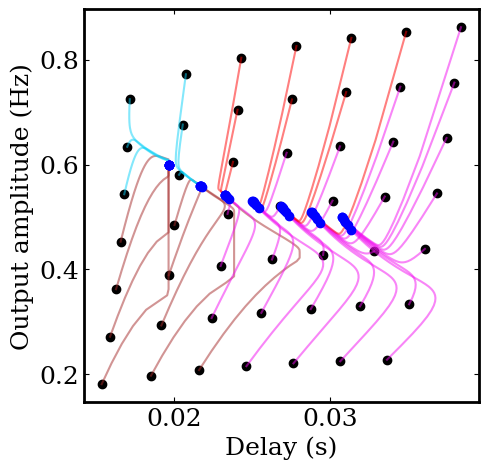

In [55]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    weight_traj = weight_trajs[i_traj, :]
    
    x_idxs = np.arange(5, len(traj), 3)
    y_idxs = np.arange(4, len(traj), 3)
    w_diff = weight_traj[-2] - weight_traj[0]
    b_diff = weight_traj[-1] - weight_traj[1]

    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8' #pink
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
    elif w_diff >= 0 and b_diff < 0:
        color = 'brown'
    else:
        color = '#f20df0' #light blue
    
    axs.plot(traj[x_idxs], traj[y_idxs], color=color, alpha=0.5, lw=1.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[5]], [traj[4]], color='black')
    axs.scatter([traj[-1]], [traj[-2]], color='blue', zorder=10)

axs.set_xlabel('Delay (s)')
axs.set_ylabel('Output amplitude (Hz)')

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.savefig('./figures/double_setpoint_amp_delay.png')
fig.savefig('./figures/double_setpoint_amp_delay.svg')

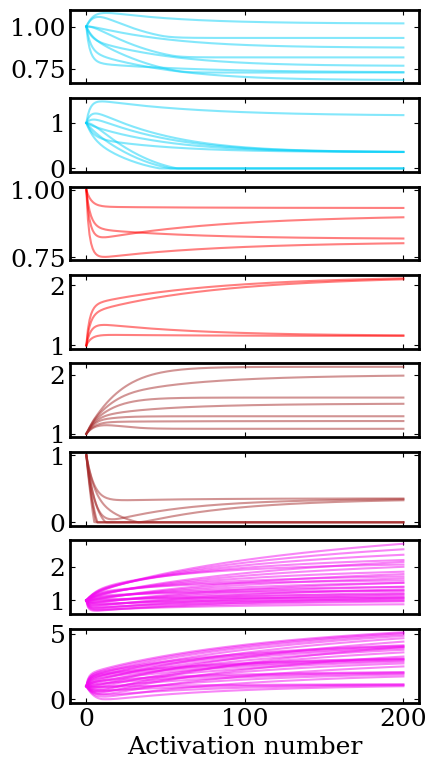

In [58]:
scale = 3
fig, axs = plt.subplots(8, 1, figsize=(1.5 * scale, 3 * scale), sharex=True)

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    weight_traj = weight_trajs[i_traj, :]
    
    w_diff = weight_traj[-2] - weight_traj[2]
    b_diff = weight_traj[-1] - weight_traj[3]
    
    w_idxs = np.arange(0, len(weight_traj), 2)
    b_idxs = np.arange(1, len(weight_traj), 2)
    
    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8' #pink
        graph_idx = 0
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
        graph_idx = 1
    elif w_diff >= 0 and b_diff < 0:
        color = 'brown'
        graph_idx = 2
    else:
        color = '#f20df0' #light blue
        graph_idx = 3
    
    axs[graph_idx * 2].plot(np.arange(len(w_idxs)), weight_traj[w_idxs] / weight_traj[0] , color=color, alpha=0.5)
    axs[graph_idx * 2 + 1].plot(np.arange(len(b_idxs)), weight_traj[b_idxs] / weight_traj[1], color=color, alpha=0.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
#     axs.scatter([traj[5]], [traj[4]], color='black')
#     axs.scatter([traj[-1]], [traj[-2]], color='red', zorder=10)

axs[7].set_xlabel('Activation number')
# axs[3].set_ylabel('Coefficient magnitude')

for i in range(8):
    axs[i].tick_params(axis='both', which='both', direction='in', right=True, top=True)
#     axs[i].set_ylim(0, 2)
# plt.subplots_adjust(wspace=0, hspace=0.05)

# fig.savefig('./figures/double_setpoint_amp_delay.png')
# fig.savefig('./figures/double_setpoint_amp_delay.svg')

In [25]:
trajs_inh = copy(trajs)

IndexError: index 22 is out of bounds for axis 1 with size 20

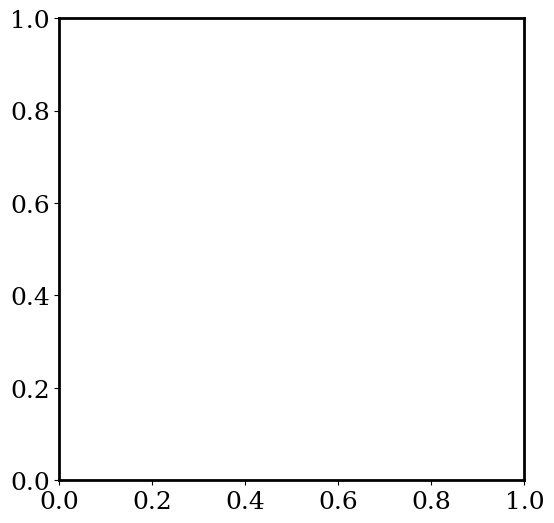

In [41]:
trajs = copy(trajs_inh)

tiling_size = 20

for i_cycle in range(n_cycles):
    if not i_cycle >= (n_cycles - 2):
        continue
#     if not (i_cycle % 1 == 0):
#         continue
    density = np.zeros((tiling_size, tiling_size))
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    for i_traj in range(trajs.shape[0]):
        traj = trajs[i_traj, :]
        density[int(traj[3 * i_cycle + 1] / 1.1 * tiling_size), int(traj[(3 * i_cycle + 2)] / 0.01 * tiling_size)] += 1
#     density /= density.sum()

    mappable = axs.matshow(density.T, vmin=0, vmax=50, cmap='hot')
    plt.colorbar(mappable, fraction=0.046, pad=0.04)
    axs.set_ylim(0, tiling_size - 1)
    axs.set_xlabel('Duration')
    axs.set_ylabel('Peak (Hz)')

In [59]:
T = 0.4 # Total duration of one network simulation
dt = 1e-4 # Timestep
t = np.linspace(0, T, int(T / dt))

def calc_alpha_func(tau_alpha):
    alpha_func_n_steps = int(10 * tau_alpha / dt)
    t_alpha = np.arange(0, alpha_func_n_steps) * dt
    return np.e * t_alpha / tau_alpha * np.exp(-t_alpha/tau_alpha)

def calc_response(inp, w, b, tau):
    r = np.zeros_like(t)
    s = np.zeros_like(t)

    for i in range(0, len(t) - 1):
        s[i+1] = s[i] + (w * inp[i] - s[i]) * dt / tau # update synaptic conductance as exponential filter of input
        r[i+1] = np.max([s[i+1] - b, 0])
    return r

w_0 = 1
b_0 = 0.1
tau = 5e-3
n_cycles = 200
w_set = 6e-7
b_set = 0.015
colors = get_ordered_colors('coolwarm', n_cycles)

trajs = np.zeros((100, (n_cycles + 1) * 3))
weight_trajs = np.zeros((100, (n_cycles + 1) * 2))

idx = 0
for tau_alpha in np.linspace(1e-3, 20e-3, 10):
    for a in np.linspace(0.01, 1, 10):
        r = np.zeros_like(t)
        w = copy(w_0)
        b = copy(b_0)
        
        inp = np.zeros_like(t)
        a_prime = a + np.random.normal(scale=0 * a)
        tau_alpha_prime = tau_alpha + np.random.normal(scale=0 * tau_alpha)
        inp_alpha = a_prime * calc_alpha_func(tau_alpha_prime)
        inp[:len(inp_alpha)] = inp_alpha
        
        m1_in = np.sum(inp * t) / np.sum(inp)
        
        traj = [tau_alpha, a, 0]
        weight_traj = [w, b]
        
        r_peak = a
        
        for i_cycle in range(n_cycles):
            r = calc_response(inp, w, b, tau)
        #     print(np.sum(np.square(r)) * dt)
            w += (100000 * (w_set - np.sum(np.square(r)) * np.square(dt)))
#             b += (2 * (np.sum(r) * dt - b_set))
            if w <= 0:
                w = 1e-8
            if b <= 0:
                b = 1e-8
                
            r_peak = np.max(r)
            m0 = np.sum(r) * dt
            m1_out = np.sum(r * t) * dt
            if m0 > 0:
                m1_out /= m0
        
            tau_out = 0
            if r_peak > 0:
                tau_out = m0 / r_peak
            traj.append(tau_out) 
            traj.append(r_peak)
            traj.append(m1_out)
            weight_traj.append(w)
            weight_traj.append(b)
        trajs[idx, :] = np.array(traj)
        weight_trajs[idx, :] = np.array(weight_traj)
        idx += 1

scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    weight_traj = weight_trajs[i_traj, :]
    
    x_idxs = np.arange(3, len(traj), 3)
    y_idxs = np.arange(4, len(traj), 3)
    w_diff = weight_traj[-2] - weight_traj[2]
    b_diff = weight_traj[-1] - weight_traj[3]
    
    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8' #pink
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
    elif w_diff >= 0 and b_diff < 0:
        color = 'brown'
    else:
        color = '#f20df0' #light blue
    axs.plot(traj[x_idxs], traj[y_idxs], color=color, alpha=0.5, lw=1.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[3]], [traj[4]], color='black')
    axs.scatter([traj[-3]], [traj[-2]], color='blue', zorder=10)

axs.set_xlabel('Output duration (s)')
axs.set_ylabel('Output amplitude (Hz)')    

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.savefig('./figures/single_w_setpoint_amp_dur.png')
fig.savefig('./figures/single_w_setpoint_amp_dur.svg')

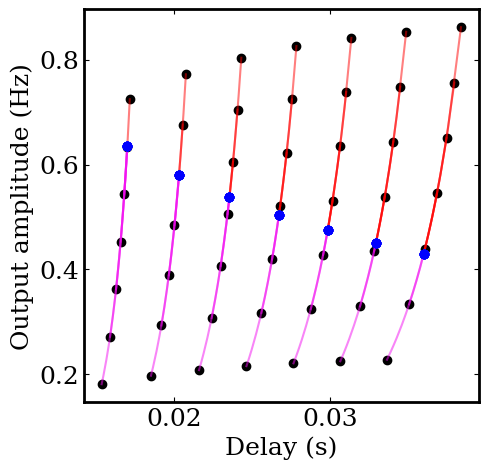

In [62]:
scale = 1.7
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

colors = get_ordered_colors('cool', len(trajs))
for i_traj in range(0, trajs.shape[0], 1):
    if i_traj % 10 < 3 or i_traj < 30:
        continue
    traj = trajs[i_traj, :]
    weight_traj = weight_trajs[i_traj, :]
    
    x_idxs = np.arange(5, len(traj), 3)
    y_idxs = np.arange(4, len(traj), 3)
    w_diff = weight_traj[-2] - weight_traj[2]
    b_diff = weight_traj[-1] - weight_traj[3]
    
    if w_diff < 0 and b_diff < 0:
        color = '#0ad1f8'
    elif w_diff < 0 and b_diff >= 0:
        color = 'red'
    elif w_diff >= 0 and b_diff < 0:
        color = 'blue'
    else:
        color = '#f20df0'
    
    axs.plot(traj[x_idxs], traj[y_idxs], color=color, alpha=0.5)
#     axs.plot(traj[[0, 2]], traj[[1, 3]], '--', color=colors[i_traj], alpha=0.5)
    axs.scatter([traj[5]], [traj[4]], color='black')
    axs.scatter([traj[-1]], [traj[-2]], color='blue', zorder=10)

axs.set_xlabel('Delay (s)')
axs.set_ylabel('Output amplitude (Hz)')

axs.tick_params(axis='both', which='both', direction='in', right=True, top=True)
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.savefig('./figures/single_w_setpoint_amp_delay.png')
fig.savefig('./figures/single_w_setpoint_amp_delay.svg')

In [29]:
trajs_exc = copy(trajs)

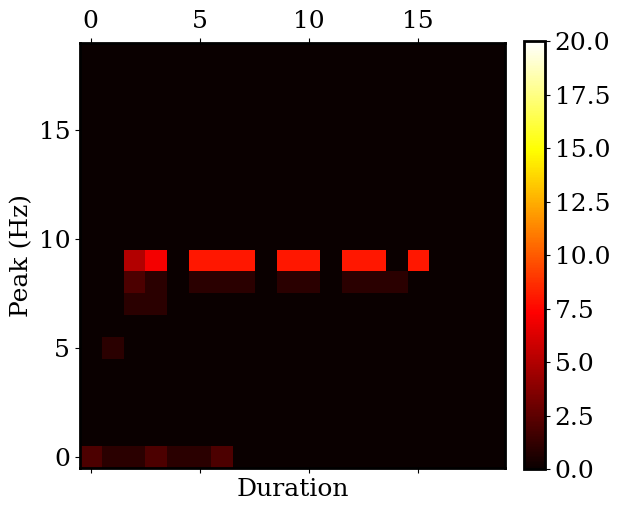

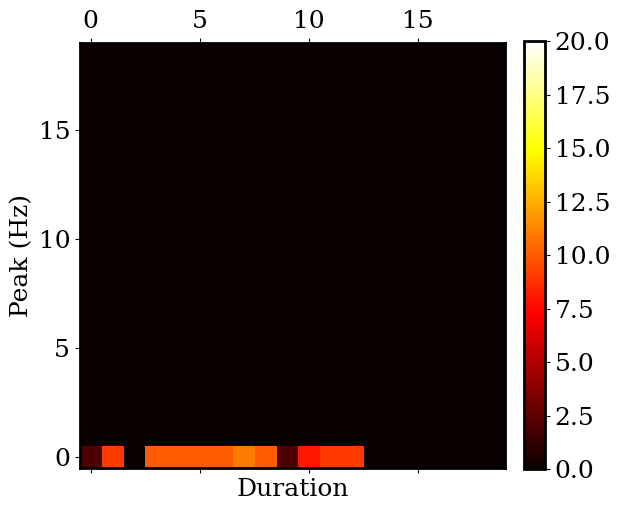

In [36]:
trajs = copy(trajs_exc)

tiling_size = 20

for i_cycle in range(n_cycles):
    if not i_cycle >= (n_cycles - 2):
        continue
#     if not (i_cycle % 1 == 0):
#         continue
    density = np.zeros((tiling_size, tiling_size))
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    for i_traj in range(trajs.shape[0]):
        traj = trajs[i_traj, :]
        density[int(traj[2 * i_cycle] / 0.06 * tiling_size), int(traj[(2 * i_cycle + 1)] / 1.1 * tiling_size)] += 1
#     density /= density.sum()

    mappable = axs.matshow(density.T, vmin=0, vmax=20, cmap='hot')
    plt.colorbar(mappable, fraction=0.046, pad=0.04)
    axs.set_ylim(-0.5, tiling_size - 1)
    axs.set_xlim(-0.5, tiling_size - 1)
    axs.set_xlabel('Duration')
    axs.set_ylabel('Peak (Hz)')

# Analytical approach
Imagine a single neuron modeled by 

$$r(t) = \left[w \int_0^t e^{-(t-t')/\tau_s}r_{\rm in}(t') - b \right]^+$$

We consider a scenario under which parameters $w$ and $b$ are controlled by learning rules that depend on the first and second moments of the postsynaptic activity. The most general reasonable version of these rules is:

\begin{equation} \label{eq_w_homeo_rule}
    \Delta w = \gamma_w \left(w_0 - \sum_{i=1}^{2} c_{i}^{(w)} M_i\right),
\end{equation}

\begin{equation} \label{eq_b_homeo_rule}
    \Delta b = \gamma_b \left(\sum_{i=1}^{2} c_{i}^{(b)} M_i - b_0\right),
\end{equation}

where $$M_1 = \int_0^{\infty} r(t) dt,$$ $$M_2 = \int_0^{\infty} r^2(t) dt.$$

For a simple form of input, i.e. $r_{\rm in}(t) = a\Theta(t)\Theta(t-T)$, $r(t)$ can be computed explicitly, permitting us to find fixed points in terms of $(w^*, b^*)$ of the latter two equations. Computing $r(t)$ under the specified form of input yields

\begin{equation} \label{eq_14}
   r(t) = \begin{cases} 
      0 & t < t^{*} \\
      wa\tau_s \left(1 - e^{-t/\tau_s}\right) - b & t^* \leq t < T \\
      wa\tau_s \left(e^{T/\tau_s} - 1\right)e^{-t/\tau_s} - b & T \leq t < t^{**} \\
      0 & t \geq t^{**}
   \end{cases}
\end{equation}

where 

\begin{equation}
   t^* = -\tau_s \log\left(1 - \frac{b}{wa\tau_s}\right)
\end{equation}
and 
\begin{equation}
   t^{**} = -\tau_s \log\left(\frac{b}{wa\tau_s (e^{T/\tau_s}-1)}\right).
\end{equation}

Here, $t^*$ represents the first moment the postsynaptic cell begins to fire and $t^{**}$ the last in response to the input. We can now compute $\int_0^{\infty} r(t)$ and $\int_0^{\infty} r^2(t)$. The peak response occurs at $t=T$, so if $wa\tau_s \left(1 - e^{-T/\tau_s}\right) \leq b$, both these integrals are zero. Otherwise, we have

\begin{equation} \label{eq_r_int}
    \begin{aligned}
        \int_0^{\infty} r(t) dt &= \int_{t^*}^{t^{**}} r(t) dt \\
                                &= (wa\tau_s - b)(T - t^*) + wa\tau^2_s \left( e^{-T/\tau_s} - e^{- t^*/\tau_s}\right)\\ &\quad+ wa\tau^2_s (1 - e^{T/\tau_s}) \left( e^{-t^{**}/\tau_s} - e^{-T/\tau_s}\right) - b(t^{**} - T) \\
    \end{aligned}
\end{equation}
and 
\begin{equation} \label{eq_r_square_int}
    \begin{aligned}
        \int_0^{\infty} r^2(t) dt &= \int_{t^*}^{t^{**}} r(t) dt \\
                                  &= (wa\tau_s -b)^2 (T - t^*) + 2wa\tau_s^2 (wa\tau_s - b) \left(e^{-T/\tau_s} - e^{-t^*/\tau_s}\right)\\ & \quad - \frac{1}{2} (wa)^2\tau_s^3 \left(e^{-2T/\tau_s} - e^{-2t^*/\tau_s}\right) + b^2 (t^{**} - T) \\ & \quad + 2bwa\tau_s^2 \left(e^{T/\tau_s} - 1\right) \left(e^{-t^{**}/\tau_s} - e^{-T/\tau_s}\right) \\ & \quad - \frac{1}{2} (wa)^2 \tau_s^3 \left(e^{T/\tau_s} - 1\right) \left(e^{-2t^{**}/\tau_s} - e^{-2T/\tau_s}\right)
    \end{aligned}
\end{equation}

We show that choosing $c_1^{(w)}=0$ and $c_2^{(b)}=0$ leads to stable fixed points in the space of $(w, b)$ while choosing $c_1^{(b)}=0$ and $c_2^{(w)}=0$ leads to saddle points.

If $c_1^{(w)}=0$ and $c_1^{(b)}=0$ or $c_2^{(w)}=0$ and $c_2^{(b)}=0$, then the rules constrain the same moment of the postsynaptic connectivity, leading to no fixed points or a stable line if $b_0 = w_0$.

We note that solutions in which all $c_i$ are nonzero can be stable.

The stability of fixed points $(w^*, b^*)$ is determined by the matrix:

$$
    \begin{pmatrix}
    \frac{\partial \Delta w}{\partial w} & \frac{\partial \Delta w}{\partial b} \\
    \frac{\partial \Delta b}{\partial w} & \frac{\partial \Delta b}{\partial b}
    \end{pmatrix} 
    =
    \begin{pmatrix}
    -\sum_{i=1}^2 c_i^{(w)} \frac{\partial M_i}{\partial w} & -\sum_{i=1}^2 c_i^{(w)} \frac{\partial M_i}{\partial b} \\
    \sum_{i=1}^2 c_i^{(b)} \frac{\partial M_i}{\partial w} & \sum_{i=1}^2 c_i^{(b)} \frac{\partial M_i}{\partial b}
    \end{pmatrix} 
$$

For any real 2 x 2 matrix, both eigenvalues are negative if $a_{11} a_{22} - a_{12} a_{21} > 0$ and the trace is negative. For the above matrix, this yields:

$$
    \left(-\sum_{i=1}^2 c_i^{(w)} \frac{\partial M_i}{\partial w}\right) \left(\sum_{i=1}^2 c_i^{(b)} \frac{\partial M_i}{\partial b}\right) - \left(-\sum_{i=1}^2 c_i^{(w)} \frac{\partial M_i}{\partial b}\right) \left(\sum_{i=1}^2 c_i^{(b)} \frac{\partial M_i}{\partial w}\right) > 0,
$$

which, after some rearranging, is

$$
    \left( c_1^{(w)} c_2^{(b)} - c_2^{(w)} c_1^{(b)} \right) \left( \frac{\partial M_2}{\partial w} \frac{\partial M_1}{\partial b} - \frac{\partial M_1}{\partial w} \frac{\partial M_2}{\partial b} \right) > 0.
$$

This condition that the trace is negative gives

$$
    c_1^{(b)} \frac{\partial M_1}{\partial b} - c_1^{(w)} \frac{\partial M_1}{\partial w} + c_2^{(b)} \frac{\partial M_2}{\partial b} - c_2^{(w)} \frac{\partial M_2}{\partial w} < 0
$$

Tested rule instantiations:

$$ c_1^{(w)} = 0, \, c_2^{(w)} = 1, \, c_1^{(b)} = 1, \, c_2^{(b)} = 0 $$

$$ c_1^{(w)} = 1, \, c_2^{(w)} = 0, \, c_1^{(b)} = 0, \, c_2^{(b)} = 1 $$

$$ c_1^{(w)} = 0, \, c_2^{(w)} = 1, \, c_1^{(b)} = 0, \, c_2^{(b)} = 0 $$

$$ c_1^{(w)} = 1, \, c_2^{(w)} = 0, \, c_1^{(b)} = 0, \, c_2^{(b)} = 0 $$

In [115]:
def comp_integrals(w, b, a, T):
    wat = w * a * tau_s
    t_star = np.where(b < 1e-6, 0, -tau_s * np.log(1 - b/wat))
    t_star_star = np.where(b < 1e-6, 1e6, -tau_s * np.log(b/(wat * (np.exp(T/tau_s) - 1))))
    exp_T = np.exp(-T/tau_s)
    exp_t_star = np.exp(-t_star/tau_s)
    exp_t_star_star = np.exp(-t_star_star/tau_s)
    b = np.where(b < 1e-6, 0, b)
    
    I1 = wat * (T - t_star) + wat * tau_s * (exp_T - exp_t_star) - b * (T - t_star) + wat * tau_s * (1 - np.exp(T / tau_s)) * (exp_t_star_star - exp_T) - b * (t_star_star - T)
    
    I2 = np.square(wat - b) * (T - t_star)
    I2 += 2 * wat * tau_s * (wat - b) * (exp_T - exp_t_star)
    I2 += -np.square(wat) * tau_s / 2 * (np.square(exp_T) - np.square(exp_t_star))
    I2 += np.square(b) * (t_star_star - T)
    I2 += 2 * b * tau_s * wat * (np.exp(T/tau_s) - 1) * (exp_t_star_star - exp_T)
    I2 += -tau_s/2 * np.square(wat * (np.exp(T/tau_s) - 1)) * (np.square(exp_t_star_star) - np.square(exp_T))
    
    I1 = np.where(wat * (1 - exp_T) > b, I1, 0)
    I2 = np.where(wat * (1 - exp_T) > b, I2, 0)
    
    return I1, I2

def comp_r_out(w, b, a, T, t):
    wat = w * a * tau_s
    t_star = np.where(b < 1e-6, 0, -tau_s * np.log(1 - b/wat))
    t_star_star = np.where(b < 1e-6, 1e6, -tau_s * np.log(b/(wat * (np.exp(T/tau_s) - 1))))
    exp_T = np.exp(-T/tau_s)
    exp_t_star = np.exp(-t_star/tau_s)
    exp_t_star_star = np.exp(-t_star_star/tau_s)
    b = np.where(b < 1e-6, 0, b)
    
    r = np.zeros(len(t))
    t_first_half_max = np.nan
    t_second_half_max = np.nan
    if wat * (1 - exp_T) > b:
        mask_1 = np.logical_and(t >= t_star, t < T)
        mask_2 = np.logical_and(t >= T, t < t_star_star)
        r[mask_1] = wat * (1 - np.exp(-t[mask_1]/tau_s)) - b
        r[mask_2] = wat * (np.exp(T/tau_s) - 1) * np.exp(-t[mask_2]/tau_s) - b
    
        r_half_max = (wat * (1 - exp_T) - b) / 2
        
        crossed_half_max = False
        for i in range(len(t)):
            if not crossed_half_max:
                if r[i] > r_half_max:
                    crossed_half_max = True
                    t_first_half_max = t[i]
            else:
                if r[i] < r_half_max:
                    crossed_half_max = False
                    t_second_half_max = t[i]
                    
        
    return r, t_first_half_max, t_second_half_max

def comp_integrals_w_cross(w, b, a, T):
    wat = w * a * tau_s
    t_star = np.where(b < 1e-6, 0, -tau_s * np.log(1 - b/wat))
    t_star_star = np.where(b < 1e-6, 1e6, -tau_s * np.log(b/(wat * (np.exp(T/tau_s) - 1))))
    exp_T = np.exp(-T/tau_s)
    exp_t_star = np.exp(-t_star/tau_s)
    exp_t_star_star = np.exp(-t_star_star/tau_s)
    b = np.where(b < 1e-6, 0, b)
    
    I1 = wat * (T - t_star) + wat * tau_s * (exp_T - exp_t_star) - b * (T - t_star) + wat * tau_s * (1 - np.exp(T / tau_s)) * (exp_t_star_star - exp_T) - b * (t_star_star - T)
    
    I2 = np.square(wat - b) * (T - t_star)
    I2 += 2 * wat * tau_s * (wat - b) * (exp_T - exp_t_star)
    I2 += -np.square(wat) * tau_s / 2 * (np.square(exp_T) - np.square(exp_t_star))
    I2 += np.square(b) * (t_star_star - T)
    I2 += 2 * b * tau_s * wat * (np.exp(T/tau_s) - 1) * (exp_t_star_star - exp_T)
    I2 += -tau_s/2 * np.square(wat * (np.exp(T/tau_s) - 1)) * (np.square(exp_t_star_star) - np.square(exp_T))
    
    exp_T_l = np.exp(-T/tau_l)
    exp_t_star_l = np.exp(-t_star/tau_l)
    exp_t_star_star_l = np.exp(-t_star_star/tau_l)
    
    X = (wat - b) * (T - t_star + tau_l * (exp_T_l - exp_t_star_l)) + wat * tau_s * (exp_T - exp_t_star)
    X += wat / t_comb_inv * (exp_T * exp_T_l - exp_t_star * exp_t_star_l)
    X += -wat / t_comb_inv * (exp_T_l - 1) * (exp_T - 1) * (exp_t_star_star * exp_t_star_star_l - exp_T * exp_T_l)
    X += -b * (exp_T_l - 1) * (t_star_star - T)
    X *= (a * tau_l)
    
    I1 = np.where(wat * (1 - exp_T) > b, I1, 0)
    I2 = np.where(wat * (1 - exp_T) > b, I2, 0)
    X = np.where(wat * (1 - exp_T) > b, X, 0)
    
    return I1, I2, X

def comp_lags_and_peaks(w, b, a, T):
    wat = w * a * tau_s
    t_star = np.where(b < 1e-6, 0, -tau_s * np.log(1 - b/wat))
    t_star_star = np.where(b < 1e-6, 1e6, -tau_s * np.log(b/(wat * (np.exp(T/tau_s) - 1))))
    exp_T = np.exp(-T/tau_s)
    exp_t_star = np.exp(-t_star/tau_s)
    exp_t_star_star = np.exp(-t_star_star/tau_s)
    b = np.where(b < 1e-6, 0, b)
    
    I1 = wat * (T - t_star) + wat * tau_s * (exp_T - exp_t_star) - b * (T - t_star) + wat * tau_s * (1 - np.exp(T / tau_s)) * (exp_t_star_star - exp_T) - b * (t_star_star - T)
    M1 = 0.5 * (wat - b) * (np.square(T) - np.square(t_star)) + wat * tau_s * ((T + tau_s) * exp_T - (t_star + tau_s) * exp_t_star)
    M1 += wat * tau_s * (np.exp(T / tau_s) - 1) * ((T + tau_s) * exp_T - (t_star_star + tau_s) * exp_t_star_star) - 0.5 * b * (np.square(t_star_star) - np.square(T))
    
    lags = np.where(wat * (1 - exp_T) > b, M1 / I1 - T/2, 0)
    peaks = np.where(wat * (1 - exp_T) > b, wat * (1 - exp_T) - b, 0)
    
    return lags, peaks
    
def comp_changes(w, b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    I1, I2 = comp_integrals(w, b, a, T)
    delta_b = b_rate * (b_coef_I1 * I1 + b_coef_I2 * I2 - b_set)
    delta_w = w_rate * (w_set - w_coef_I2 * I2 - w_coef_I1 * I1)
    return delta_w, delta_b

def comp_changes_arr(x, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    return np.array(comp_changes(x[0], x[1], a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2))

def comp_changes_fixed_b(x, b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    delta_w, delta_b = np.array(comp_changes(x[0], b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2))
    return np.array(delta_w)

def comp_changes_fixed_w(x, w, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    delta_w, delta_b = comp_changes(w, x[0], a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
    return np.array(delta_b)

def comp_changes_stdp(w, b, a, T, w_set, b_set, w_rate, b_rate, stdp_rate):
    I1, I2, X = comp_integrals_w_cross(w, b, a, T)
    delta_b = b_rate * (I2 - b_set)
    delta_w = w_rate * (w_set + stdp_rate * X - w * I2)
    return delta_w, delta_b

def comp_changes_stdp_arr(x, a, T, w_set, b_set, w_rate, b_rate, stdp_rate):
    return np.array(comp_changes_stdp(x[0], x[1], a, T, w_set, b_set, w_rate, b_rate, stdp_rate))

def fixed_point_eq(a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    return partial(comp_changes_arr, a=a, T=T, w_set=w_set, b_set=b_set, w_rate=w_rate, b_rate=b_rate, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

def fixed_point_eq_fixed_b(b, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    return partial(comp_changes_fixed_b, b=b, a=a, T=T, w_set=w_set, b_set=b_set, w_rate=w_rate, b_rate=b_rate, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

def fixed_point_eq_fixed_w(w, a, T, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2):
    return partial(comp_changes_fixed_w, w=w, a=a, T=T, w_set=w_set, b_set=b_set, w_rate=w_rate, b_rate=b_rate, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

def find_fixed_point(a, T, w_set, b_set, w_rate=1, b_rate=1, w_coef_I1=1, w_coef_I2=1, b_coef_I1=1, b_coef_I2=1, w=None, b=None):
    valid_solns_mask = np.zeros(len(a.flatten()), dtype=bool)
    solns = []
    
    guess_solns_fixed_bias = np.array([
        [30],
        [120],
    ])
    
    if w_rate != 0 and b_rate != 0:
    
        guess_solns = np.array([
            [30, 1],
            [120, 1],
            [30, 0.1],
            [120, 0.1],
        ])
    
        for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
            f = fixed_point_eq(a_i, T_i, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
            soln_found = False
            for i_x in range(guess_solns.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(2)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(soln)
                        soln_found = True
                        
            f = fixed_point_eq_fixed_b(0, a_i, T_i, w_set, b_set, w_rate, 0, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
            for i_x in range(guess_solns_fixed_bias.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns_fixed_bias[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(1)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(np.array([soln[0], 0]))
                        soln_found = True
    
    elif w_rate != 0:

        for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
            f = fixed_point_eq_fixed_b(b, a_i, T_i, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
            soln_found = False
            for i_x in range(guess_solns_fixed_bias.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns_fixed_bias[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(1)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(soln)
                        soln_found = True
                        
    else:
        guess_solns_ignore_weight = np.array([
            [1],
            [0.1],
        ])
    
        for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
            f = fixed_point_eq_fixed_w(w, a_i, T_i, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
            soln_found = False
            for i_x in range(guess_solns_ignore_weight.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns_ignore_weight[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(1)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(soln)
                        soln_found = True
            
    solns = np.array(solns)
    return solns, valid_solns_mask

def fixed_point_eq_stdp(a, T, w_set, b_set, w_rate, b_rate, stdp_rate):
    return partial(comp_changes_stdp_arr, a=a, T=T, w_set=w_set, b_set=b_set, w_rate=w_rate, b_rate=b_rate, stdp_rate=stdp_rate)

def find_fixed_point_stdp(a, T, w_set, b_set, w_rate=1, b_rate=1, stdp_rate=1, w=None, b=None):
    valid_solns_mask = np.zeros(len(a.flatten()), dtype=bool)
    solns = []
    
    guess_solns_fixed_bias = np.array([
        [30],
        [120],
    ])
    
    if w_rate != 0 and b_rate != 0:
    
        guess_solns = np.array([
            [30, 1],
            [120, 1],
            [30, 0.1],
            [120, 0.1],
        ])
    
        for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
            f = fixed_point_eq_stdp(a_i, T_i, w_set, b_set, w_rate, b_rate, stdp_rate)
            soln_found = False
            for i_x in range(guess_solns.shape[0]):
                if not soln_found:
                    soln = fsolve(f, guess_solns[i_x, :], maxfev=10000)
                    zero = f(soln)
                    if np.isclose(zero, np.zeros(2)).all():
                        valid_solns_mask[i_z] = True
                        solns.append(soln)
                        soln_found = True
                        
#             f = fixed_point_eq_fixed_b(0, a_i, T_i, w_set, b_set, w_rate, 0, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
#             for i_x in range(guess_solns_fixed_bias.shape[0]):
#                 if not soln_found:
#                     soln = fsolve(f, guess_solns_fixed_bias[i_x, :], maxfev=10000)
#                     zero = f(soln)
#                     if np.isclose(zero, np.zeros(1)).all():
#                         valid_solns_mask[i_z] = True
#                         solns.append(np.array([soln[0], 0]))
#                         soln_found = True
    
#     elif w_rate != 0:

#         for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
#             f = fixed_point_eq_fixed_b(b, a_i, T_i, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
#             soln_found = False
#             for i_x in range(guess_solns_fixed_bias.shape[0]):
#                 if not soln_found:
#                     soln = fsolve(f, guess_solns_fixed_bias[i_x, :], maxfev=10000)
#                     zero = f(soln)
#                     if np.isclose(zero, np.zeros(1)).all():
#                         valid_solns_mask[i_z] = True
#                         solns.append(soln)
#                         soln_found = True
                        
#     else:
#         guess_solns_ignore_weight = np.array([
#             [1],
#             [0.1],
#         ])
    
#         for i_z, (a_i, T_i) in enumerate(zip(a.flatten(), T.flatten())):
#             f = fixed_point_eq_fixed_w(w, a_i, T_i, w_set, b_set, w_rate, b_rate, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
#             soln_found = False
#             for i_x in range(guess_solns_ignore_weight.shape[0]):
#                 if not soln_found:
#                     soln = fsolve(f, guess_solns_ignore_weight[i_x, :], maxfev=10000)
#                     zero = f(soln)
#                     if np.isclose(zero, np.zeros(1)).all():
#                         valid_solns_mask[i_z] = True
#                         solns.append(soln)
#                         soln_found = True
            
    solns = np.array(solns)
    return solns, valid_solns_mask

def comp_derivatives(w, b, a, T, w_coef_I1=1, w_coef_I2=1, b_coef_I1=1, b_coef_I2=1):
    wat = w * a * tau_s
    t_star = np.where(b < 1e-6, 0, -tau_s * np.log(1 - b/wat))
    t_star_star = np.where(b < 1e-6, 1e6, -tau_s * np.log(b/(wat * (np.exp(T/tau_s) - 1))))
    exp_T = np.exp(-T/tau_s)
    exp_t_star = np.exp(-t_star/tau_s)
    exp_t_star_star = np.exp(-t_star_star/tau_s)
    b = np.where(b < 1e-6, 0, b)
    
    dt_star_dw = tau_s / (w * (1 - wat/b))
    dexp_t_star_dw = b / (np.square(w) * a * tau_s)
    dt_star_star_dw = tau_s / w
    dexp_t_star_star_dw = -b / (w * wat * (np.exp(T/tau_s) - 1))
    
    dt_star_db = tau_s / (wat - b)
    dexp_t_star_db = -1 / wat
    dt_star_star_db = -tau_s / b
    dexp_t_star_star_db = 1 / (wat * (np.exp(T/tau_s) - 1))
    
    dI1_dw = a * tau_s * (T - t_star) - (wat - b) * dt_star_dw + a * np.square(tau_s) * (exp_T - exp_t_star)
    dI1_dw += -wat * tau_s * dexp_t_star_dw
    dI1_dw += (1 - np.exp(T/tau_s)) * (a * np.square(tau_s) * (exp_t_star_star - exp_T) + wat * tau_s * dt_star_star_dw)
    dI1_dw += -b * dt_star_star_dw
    
    dI1_db = -b * (T - t_star) - (wat - b) * dt_star_db - wat * tau_s * dexp_t_star_db
    dI1_db += wat * tau_s * (1 - np.exp(T/tau_s)) * dexp_t_star_star_db - (t_star_star - T) - b * dt_star_star_db
    
    dI2_dw = 2 * (wat - b) * a * tau_s * (T - t_star) - np.square(wat - b) * dt_star_dw
    dI2_dw += 2 * a * np.square(tau_s) * (wat - b) * (exp_T - exp_t_star)
    dI2_dw += 2 * wat * tau_s * (a * tau_s * (exp_T - exp_t_star) - (wat - b) * dexp_t_star_dw)
    dI2_dw += w * np.square(a) + tau_s**3 * (np.square(exp_T) - np.square(exp_t_star))
    dI2_dw += np.square(a * tau_s) * tau_s**3 * exp_t_star * dexp_t_star_dw + np.square(b) * dt_star_star_dw
    dI2_dw += (np.exp(T/tau_s) - 1) * (2 * b * a * np.square(tau_s) * ((exp_t_star_star - exp_T) + w * dexp_t_star_star_dw))
    dI2_dw += -(np.exp(T/tau_s) - 1) * np.square(a) * tau_s**3 * w * ((np.square(exp_t_star_star) - np.square(exp_T)) + w * exp_t_star_star * dexp_t_star_star_dw)
    
    dI2_db = -2 * (wat - b) * (T - t_star) - np.square(wat - b) * dt_star_db - 2 * wat * tau_s * (exp_T - exp_t_star)
    dI2_db += -2 * wat * tau_s * (wat - b) * dexp_t_star_db + np.square(wat) * tau_s * exp_t_star * dexp_t_star_db
    dI2_db += 2 * b * (t_star_star - T) + np.square(b) * dt_star_star_db
    dI2_db += (np.exp(T/tau_s) - 1) * (2 * wat * tau_s * (exp_t_star_star - exp_T + b * dexp_t_star_star_db) + np.square(wat) * tau_s * exp_t_star_star * dexp_t_star_star_db)
    
    return -(w_coef_I1 * dI1_dw + w_coef_I2 * dI2_dw), -(w_coef_I1 * dI1_db + w_coef_I2 * dI2_db), (b_coef_I1 * dI1_dw + b_coef_I2 * dI2_dw), (b_coef_I1 * dI1_db + b_coef_I2 * dI2_db)

[40.63990283  0.29686368]
(array([-4.06399039e+03, -8.78823905e-03]), array([[-1.00000000e+00, -4.10253896e-06],
       [ 7.21177101e-08, -1.00000000e+00]]))
[42.3550435   0.42645672]
(array([-4.23550448e+03, -8.94514649e-03]), array([[-1.00000000e+00, -3.81103666e-06],
       [ 7.22874630e-08, -1.00000000e+00]]))
[49.90795997  0.81067903]
(-4990.796446977672, 0.02602647410051182, 4990.796446977672, -0.02602647410051182)


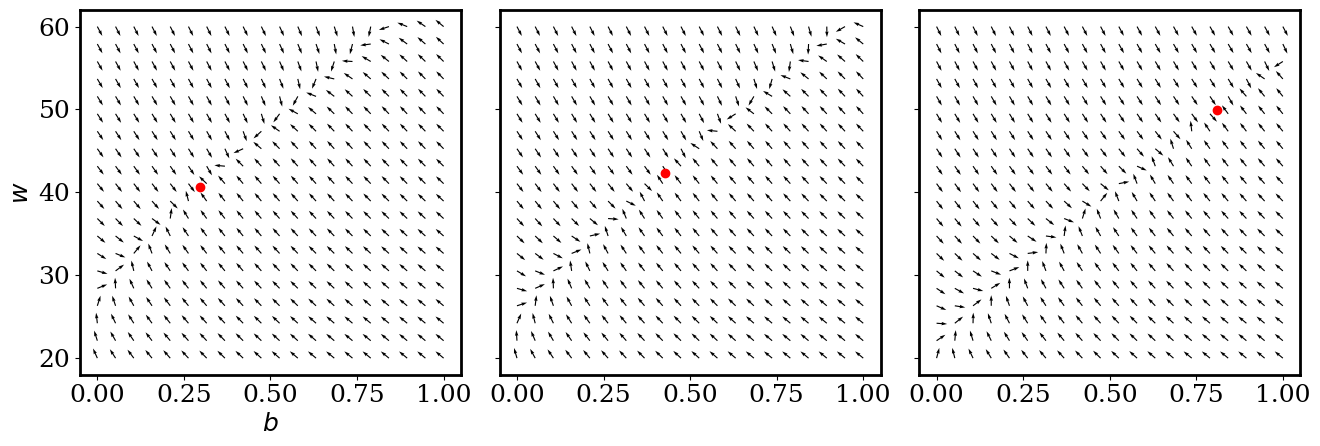

In [116]:
tau_s = 0.004
w_set = 0.0075
b_set = 0.009

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(20, 60, 20), np.linspace(0, 1, 20))

# panel 1
T = np.array([0.009])
a = np.array([10])

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 1
b_coef_I2 = 0

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
fixed_point = fixed_points[0]
print(fixed_point)
axs[0].scatter(fixed_point[1], fixed_point[0], color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0],
                          w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
derivs_mat = np.array([[derivs[0], derivs[1]], [derivs[2], derivs[3]]])
print(np.linalg.eig(derivs_mat))

# panel 2
T = np.array([0.010])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
fixed_point = fixed_points[0]
print(fixed_point)
axs[1].scatter(fixed_point[1], fixed_point[0], color='red')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0],
                          w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
derivs = np.array([[derivs[0], derivs[1]], [derivs[2], derivs[3]]])
print(np.linalg.eig(derivs))

# panel 3
T = np.array([0.012])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=0, b_coef_I2=0)
fixed_point = fixed_points[0]
print(fixed_point)
axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

print(comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0]))

fig.tight_layout()



[40.18440474  0.19738289]
(array([ 6.09889814, -6.11626033]), array([[ 0.00152198, -0.00151779],
       [ 0.99999884,  0.99999885]]))
[42.3550435   0.42645672]
(array([ 6.14704016, -6.16348796]), array([[ 0.00145512, -0.00145138],
       [ 0.99999894,  0.99999895]]))
[49.90795997  0.81067903]
(array([ 7.54835494, -7.56326177]), array([[ 0.00151538, -0.00151252],
       [ 0.99999885,  0.99999886]]))


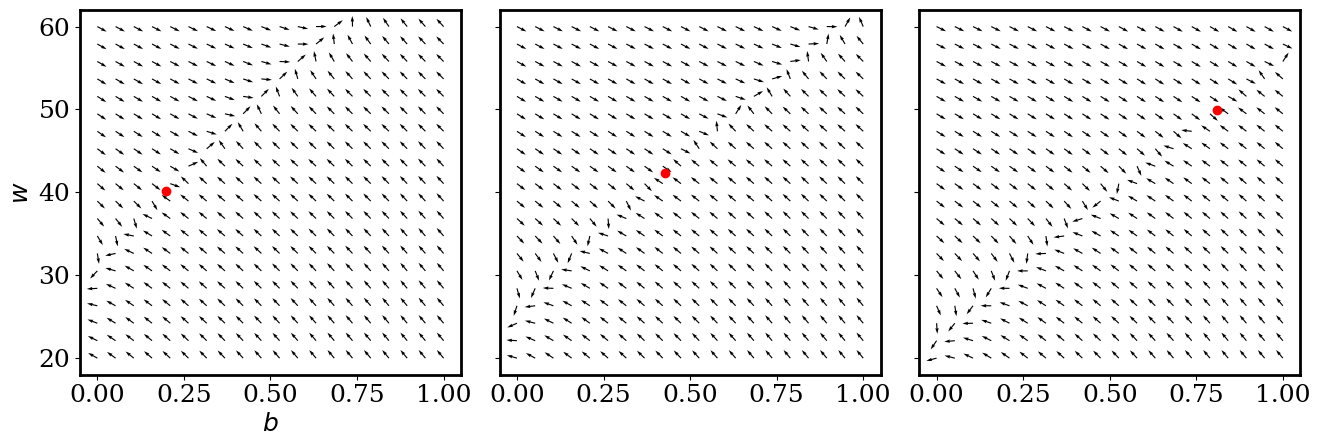

In [5]:
tau_s = 0.004
w_set = 0.009
b_set = 0.0075

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(20, 60, 20), np.linspace(0, 1, 20))

# panel 1
T = np.array([0.008])
a = np.array([10])

w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 1


delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[0].scatter(fixed_point[1], fixed_point[0], color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0],
                          w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
derivs_mat = np.array([[derivs[0], derivs[1]], [derivs[2], derivs[3]]])
print(np.linalg.eig(derivs_mat))

# panel 2
T = np.array([0.01])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[1].scatter(fixed_point[1], fixed_point[0], color='red')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0],
                          w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
derivs_mat = np.array([[derivs[0], derivs[1]], [derivs[2], derivs[3]]])
print(np.linalg.eig(derivs_mat))

# panel 3
T = np.array([0.012])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0.25, w_coef_I1, w_coef_I2, b_coef_I1, b_coef_I2)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
fixed_point = fixed_points[0]
print(fixed_point)
axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0],
                          w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
derivs_mat = np.array([[derivs[0], derivs[1]], [derivs[2], derivs[3]]])
print(np.linalg.eig(derivs_mat))

fig.tight_layout()


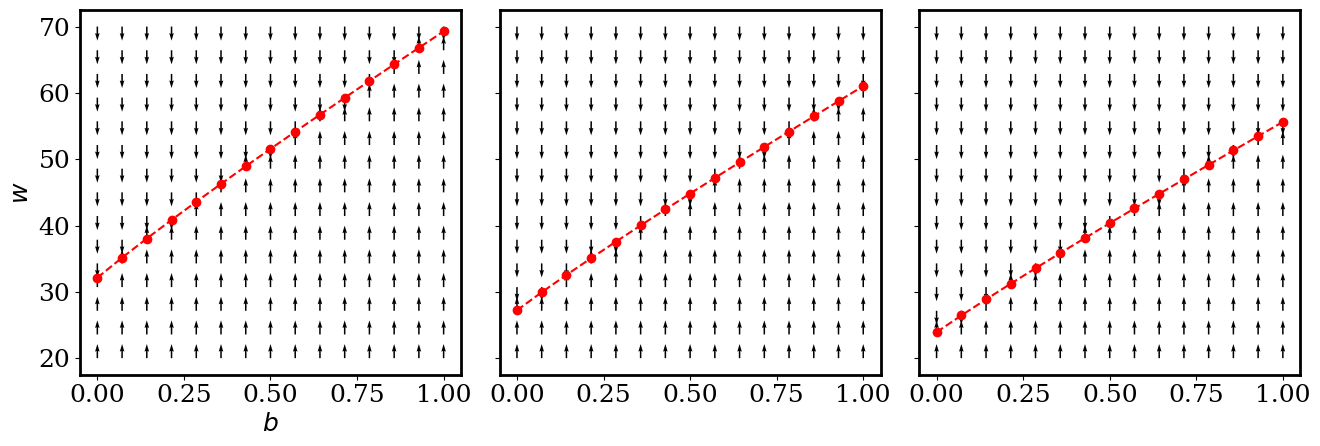

In [151]:
w_set = 0.0075
b_set = 0
tau_s = 0.004

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
b_vals = np.linspace(0, 1, 15)
w, b = np.meshgrid(np.linspace(20, 70, 15), b_vals)

# panel 1
T = np.array([0.008])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 0, 1, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I1=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[0].plot(b_vals, w_fixed, '--', color='red')
axs[0].scatter(b_vals, w_fixed, color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# panel 1
T = np.array([0.01])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 0, 1, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I1=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[1].plot(b_vals, w_fixed, '--', color='red')
axs[1].scatter(b_vals, w_fixed, color='red')

# panel 1
T = np.array([0.012])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 0, 1, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I1=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[2].plot(b_vals, w_fixed, '--', color='red')
axs[2].scatter(b_vals, w_fixed, color='red')

fig.tight_layout()

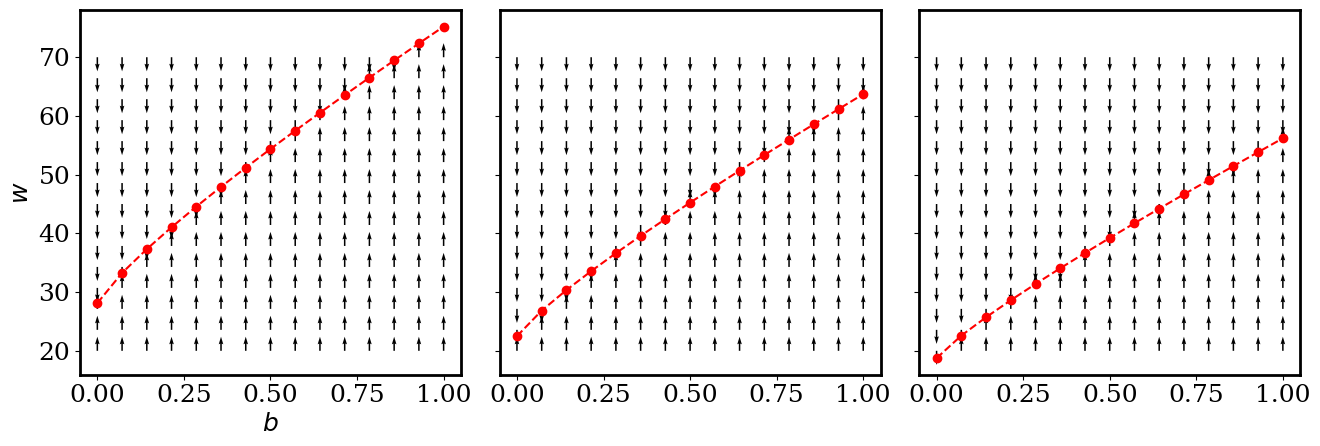

In [227]:
w_set = 0.009
b_set = 0
tau_s = 0.004

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
b_vals = np.linspace(0, 1, 15)
w, b = np.meshgrid(np.linspace(20, 70, 15), b_vals)

# panel 1
T = np.array([0.008])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 1, 0, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I2=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[0].plot(b_vals, w_fixed, '--', color='red')
axs[0].scatter(b_vals, w_fixed, color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# panel 1
T = np.array([0.01])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 1, 0, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I2=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[1].plot(b_vals, w_fixed, '--', color='red')
axs[1].scatter(b_vals, w_fixed, color='red')

# panel 1
T = np.array([0.012])
a = np.array([10])

delta_w, delta_b = comp_changes(w, b, a, T, w_set, b_set, 0.25, 0, 1, 0, 0, 0)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

w_fixed = []
for b_val_i in b_vals:
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b=b_val_i, b_rate=0, w_coef_I2=0, b_coef_I2=0)
    w_fixed.append(fixed_points[0][0])
axs[2].plot(b_vals, w_fixed, '--', color='red')
axs[2].scatter(b_vals, w_fixed, color='red')

fig.tight_layout()

Now that we have a technique for finding the fixed points of the $\left(w, b\right)$ given the input, we can find the stable responses for many different $\left(T, a\right)$.

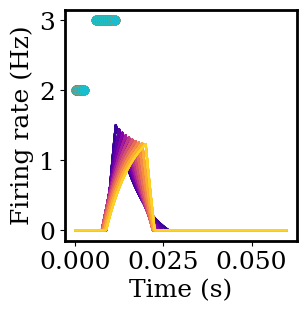

In [136]:
tau_s = 0.008
w_set = 0.009
b_set = 0.01

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 1
b_coef_I2 = 0

a_plot, T_plot = np.meshgrid(np.linspace(2, 20, 10), np.linspace(0.003, 0.02, 10))
fixed_points, valid_solns_mask = find_fixed_point(a_plot, T_plot, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

T_max_half = T_plot.max() / 2

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

n_lines = 110
cmap = mpl.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

dt = 0.00005
t = np.linspace(0, 0.06, int(0.06 / dt))

all_r_outs_adjusted = []

for i in range(fixed_points.shape[0]):
    r_out, t_first_half_max, t_second_half_max = comp_r_out(fixed_points[i, 0], fixed_points[i, 1], a_plot.flatten()[i], T_plot.flatten()[i], t)
    half_T = (T_plot.flatten()[i] / 2)
    r_out_adjust = np.concatenate([np.zeros(int((T_max_half - half_T) / dt)), r_out])
    r_out_adjust = r_out_adjust[:int(0.06/dt)]
    all_r_outs_adjusted.append(r_out_adjust)
    axs.plot(np.arange(len(r_out_adjust)) * dt, r_out_adjust, c=colors[i])
    axs.scatter([t_second_half_max - half_T, t_first_half_max - half_T], [3, 2])
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing rate (Hz)')

all_r_outs_adjusted = np.array(all_r_outs_adjusted)
all_r_outs_adjusted = all_r_outs_adjusted / all_r_outs_adjusted.sum(axis=1).reshape(len(a_plot.flatten()), 1)
print('')




Text(0, 0.5, 'Firing rate (Hz)')

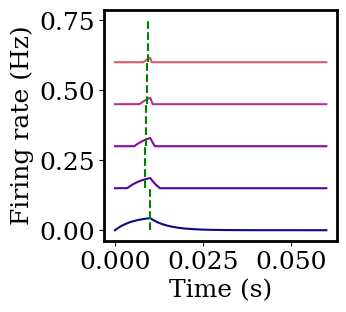

In [153]:
tau_s = 0.005
w_set = 0.009
b_set = 0.01

w = np.linspace(1, 5, 5)
b = np.linspace(0, 0.2, 5)

a_plot, T_plot = np.meshgrid(np.linspace(10, 10, 4), np.linspace(0.01, 0.01, 4))

T_max_half = T_plot.max() / 2

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

n_lines = 8
cmap = mpl.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

dt = 0.00005
t = np.linspace(0, 0.06, int(0.06 / dt))

all_r_outs_adjusted = []

for i in range(w.shape[0]):
    r_out, t_first_half_max, t_second_half_max = comp_r_out(w[i], b[i], a_plot.flatten()[i], T_plot.flatten()[i], t)
    t_mean = np.sum(t * r_out) / np.sum(r_out)
#     r_out_adjust = np.concatenate([np.zeros(int((T_max_half - half_T) / dt)), r_out])
#     r_out_adjust = r_out_adjust[:int(0.06/dt)]
    all_r_outs_adjusted.append(r_out)
    axs.plot(np.arange(len(r_out)) * dt, r_out + 0.15 * i, c=colors[i])
    axs.plot(t_mean * np.ones(2), 0.15 * i + np.array([0, 0.15]), '--', color='green')
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing rate (Hz)')

Text(0, 0.5, 'Firing rate (Hz)')

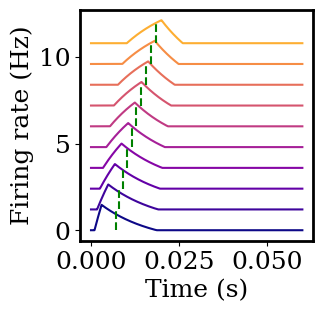

In [208]:
tau_s = 0.015
w_set = 0.01
b_set = 0.011

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 1
b_coef_I2 = 0

a_plot, T_plot = np.meshgrid(np.linspace(10, 10, 1), np.linspace(0.003, 0.02, 10))
fixed_points, valid_solns_mask = find_fixed_point(a_plot, T_plot, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

n_lines = 12
cmap = mpl.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

dt = 0.00005
t = np.linspace(0, 0.06, int(0.06 / dt))

all_r_outs_adjusted = []

for i in range(fixed_points.shape[0]):
    r_out, t_first_half_max, t_second_half_max = comp_r_out(fixed_points[i, 0], fixed_points[i, 1], a_plot.flatten()[i], T_plot.flatten()[i], t)
    t_mean = np.sum(t * r_out) / np.sum(r_out)
#     r_out_adjust = np.concatenate([np.zeros(int((T_max_half - half_T) / dt)), r_out])
#     r_out_adjust = r_out_adjust[:int(0.06/dt)]
    all_r_outs_adjusted.append(r_out)
    axs.plot(np.arange(len(r_out)) * dt, r_out + 1.2 * i, c=colors[i])
    axs.plot(t_mean * np.ones(2), 1.2 * i + np.array([0, 1.2]), '--', color='green')
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing rate (Hz)')

Text(0, 0.5, 'Firing rate (Hz)')

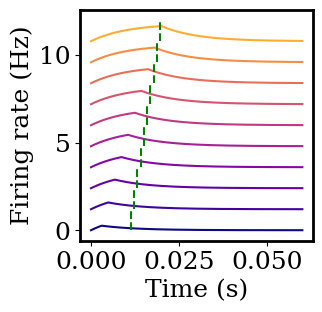

In [213]:
tau_s = 0.01
w_set = 0.006
b_set = np.nan

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 0
b_coef_I2 = 0

b_fixed = 0

a_plot, T_plot = np.meshgrid(np.linspace(10, 10, 1), np.linspace(0.003, 0.02, 10))
T_max_half = T_plot.max() / 2
fixed_points, valid_solns_mask = find_fixed_point(a_plot, T_plot, w_set, 0, b_rate=0, b=b_fixed, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

n_lines = 12
cmap = mpl.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

dt = 0.00005
t = np.linspace(0, 0.06, int(0.06 / dt))

all_r_outs_adjusted = []

for i in range(fixed_points.shape[0]):
    r_out, t_first_half_max, t_second_half_max = comp_r_out(10, b_fixed, a_plot.flatten()[i], T_plot.flatten()[i], t)
#     half_T = T_plot.flatten()[i] / 2
#     r_out_adjust = np.concatenate([np.zeros(int((T_max_half - half_T) / dt)), r_out])
#     r_out_adjust = r_out_adjust[:int(0.06/dt)]
    t_mean = np.sum(t * r_out) / np.sum(r_out)
    axs.plot(np.arange(len(r_out)) * dt, r_out + 1.2 * i, c=colors[i])
    axs.plot(t_mean * np.ones(2), 1.2 * i + np.array([0, 1.2]), '--', color='green')
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing rate (Hz)')

In [132]:
tau_s = 0.006
w_set = 0.01
b_set = 0.012

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 1
b_coef_I2 = 0

a, T = np.meshgrid(np.linspace(2, 20, 100), np.linspace(0.003, 0.02, 100))

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
np.count_nonzero(valid_solns_mask)

10000

stable_count 9481
[0.006      0.006      0.006      ... 0.00513787 0.00513787 0.00513787]
2.6784788952403083e-07 0.01832895655727683


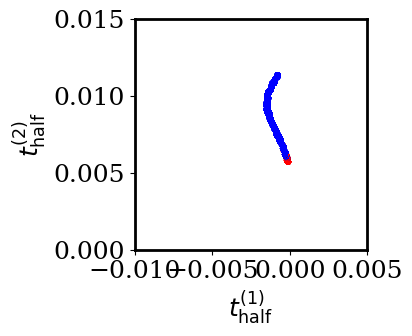

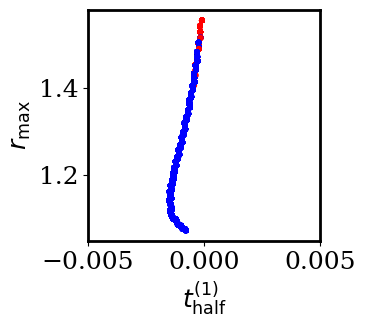

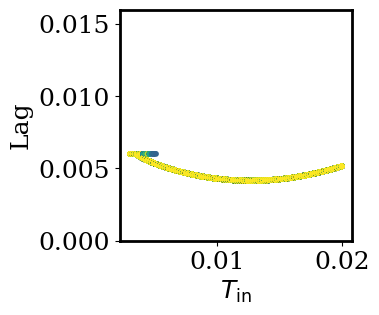

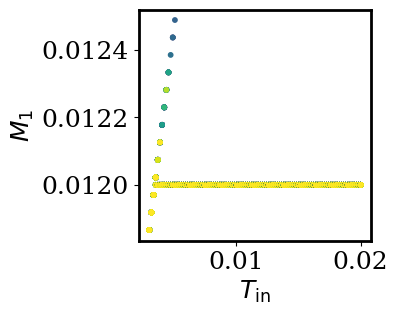

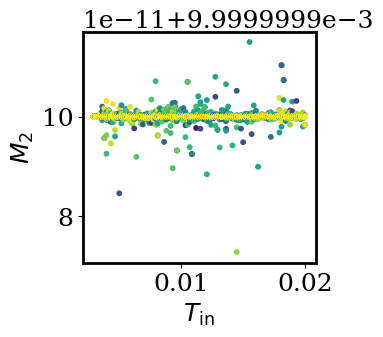

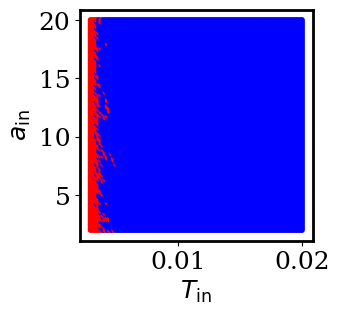

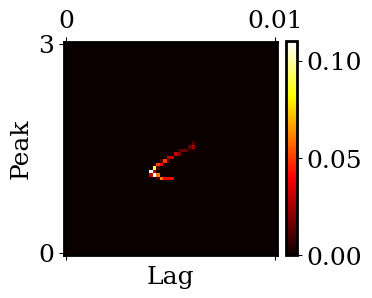

In [133]:
dt = 0.0001
t = np.linspace(0, 0.06, int(0.06 / dt))

a_valid = a.flatten()[valid_solns_mask]
T_valid = T.flatten()[valid_solns_mask]

I1, I2 = comp_integrals(fixed_points[:, 0], fixed_points[:, 1], a_valid, T_valid)
lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], fixed_points[:, 1], a_valid, T_valid)

t_first_half_maxes = np.empty((fixed_points.shape[0]))
t_second_half_maxes = np.empty((fixed_points.shape[0]))

for i in range(fixed_points.shape[0]):
    r_out, t_first_half_max, t_second_half_max = comp_r_out(fixed_points[i, 0], fixed_points[i, 1], a_valid[i], T_valid[i], t)
    t_first_half_maxes[i] = t_first_half_max - T_valid[i] / 2
    t_second_half_maxes[i] = t_second_half_max - T_valid[i] / 2
    
derivs = comp_derivatives(np.array(fixed_points[:, 0]), np.array(fixed_points[:, 1]), a_valid, T_valid,
                          w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
derivs = np.array(derivs)
derivs = derivs.reshape(2, 2, derivs.shape[1])

stable_count = 0
stable = np.zeros(fixed_points.shape[0])

for k in range(derivs.shape[-1]):
    derivs_k = derivs[..., k]
    if not np.isnan(derivs_k).any():
        eigen_vals = np.linalg.eig(derivs[..., k])[0]
        if (eigen_vals < 0).all() and not np.isclose(eigen_vals, 0).any():
            stable_count += 1
            stable[k] = 1

print('stable_count', stable_count)
stable_colors = ['blue' if i == 1 else 'red' for i in stable]

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(t_first_half_maxes, t_second_half_maxes, c=stable_colors, s=10)
axs.set_xlim(-0.01, 0.005)
axs.set_ylim(0, 0.015)
axs.set_xlabel(r'$t_{\rm half}^{(1)}$')
axs.set_ylabel(r'$t_{\rm half}^{(2)}$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(t_first_half_maxes, peaks, c=stable_colors, s=10)
axs.set_xlim(-0.005, 0.005)
# axs.set_ylim(0, 0.015)
axs.set_xlabel(r'$t_{\rm half}^{(1)}$')
axs.set_ylabel(r'$r_{\rm max}$')


scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(T_valid, lags, c=a_valid, s=10)
axs.set_ylim(0, 0.016)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'Lag')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T_valid, I1, c=a_valid, s=10)
lag_max = 0.02
lag_min = 0
I1_max = 0.02
I1_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_1$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T_valid, I2, c=a_valid, s=10)
lag_max = 0.01
lag_min = 0
I1_max = 0.02
I1_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_2$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T_valid, a_valid, c=stable_colors, s=10)
lag_max = 0.01
lag_min = 0
peak_max = 3
peak_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$a_{\rm in}$')

print(lags)

tiling_size = 60
density = np.zeros((tiling_size, tiling_size))
for lag, peak in zip(lags, peaks):
    i_peak = int((peak - peak_min) / (peak_max - peak_min) * tiling_size)
    i_lag = int((lag - lag_min) / (lag_max - lag_min) * tiling_size)
    density[i_peak, i_lag] += 1
    
density = density / density.sum()

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(density, cmap='hot', origin='lower', vmin=0)
axs.set_xticks([0, tiling_size - 1])
axs.set_xticklabels([lag_min, lag_max])
axs.set_yticks([0, tiling_size - 1])
axs.set_yticklabels([peak_min, peak_max])
fig.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_xlabel('Lag')
axs.set_ylabel(r'Peak')

print(np.var(lags), np.var(peaks))

In [134]:
tau_s = 0.006
w_set = 0.012
b_set = 0.01

w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 1

a, T = np.meshgrid(np.linspace(2, 20, 100), np.linspace(0.003, 0.02, 100))

fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
np.count_nonzero(valid_solns_mask)

10000

stable_count 0
[0.006      0.006      0.006      ... 0.00513787 0.00513787 0.00513787]
2.6047588096590115e-07 0.018534705177830763


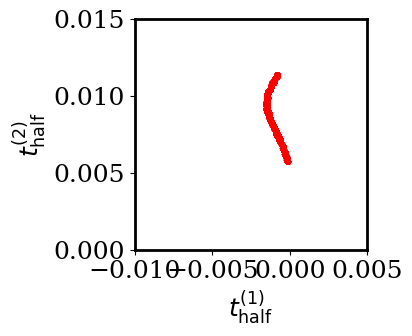

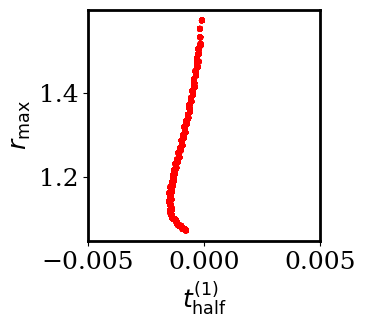

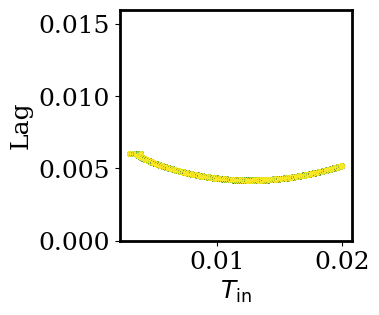

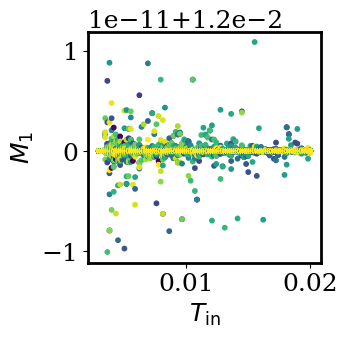

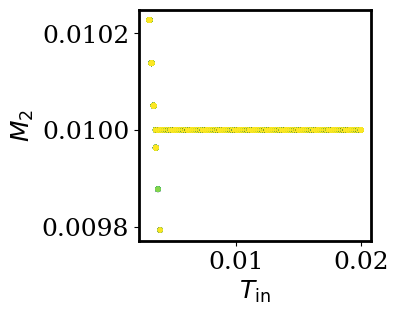

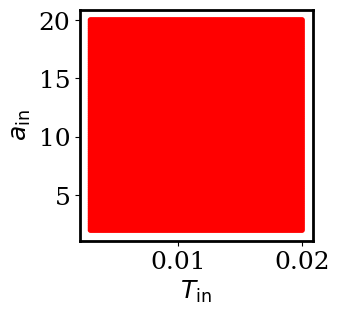

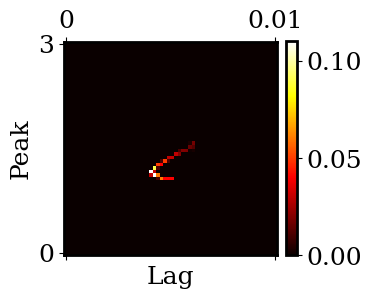

In [135]:
dt = 0.0001
t = np.linspace(0, 0.06, int(0.06 / dt))

a_valid = a.flatten()[valid_solns_mask]
T_valid = T.flatten()[valid_solns_mask]

I1, I2 = comp_integrals(fixed_points[:, 0], fixed_points[:, 1], a_valid, T_valid)
lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], fixed_points[:, 1], a_valid, T_valid)

t_first_half_maxes = np.empty((fixed_points.shape[0]))
t_second_half_maxes = np.empty((fixed_points.shape[0]))

for i in range(fixed_points.shape[0]):
    r_out, t_first_half_max, t_second_half_max = comp_r_out(fixed_points[i, 0], fixed_points[i, 1], a_valid[i], T_valid[i], t)
    t_first_half_maxes[i] = t_first_half_max - T_valid[i] / 2
    t_second_half_maxes[i] = t_second_half_max - T_valid[i] / 2
    
derivs = comp_derivatives(np.array(fixed_points[:, 0]), np.array(fixed_points[:, 1]), a_valid, T_valid,
                          w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
derivs = np.array(derivs)
derivs = derivs.reshape(2, 2, derivs.shape[1])

stable_count = 0
stable = np.zeros(fixed_points.shape[0])

for k in range(derivs.shape[-1]):
    derivs_k = derivs[..., k]
    if not np.isnan(derivs_k).any():
        eigen_vals = np.linalg.eig(derivs[..., k])[0]
        if (eigen_vals < 0).all() and not np.isclose(eigen_vals, 0).any():
            stable_count += 1
            stable[k] = 1

print('stable_count', stable_count)
stable_colors = ['blue' if i == 1 else 'red' for i in stable]

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(t_first_half_maxes, t_second_half_maxes, c=stable_colors, s=10)
axs.set_xlim(-0.01, 0.005)
axs.set_ylim(0, 0.015)
axs.set_xlabel(r'$t_{\rm half}^{(1)}$')
axs.set_ylabel(r'$t_{\rm half}^{(2)}$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(t_first_half_maxes, peaks, c=stable_colors, s=10)
axs.set_xlim(-0.005, 0.005)
# axs.set_ylim(0, 0.015)
axs.set_xlabel(r'$t_{\rm half}^{(1)}$')
axs.set_ylabel(r'$r_{\rm max}$')



scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T_valid, lags, c=a_valid, s=10)
axs.set_ylim(0, 0.016)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'Lag')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T_valid, I1, c=a_valid, s=10)
lag_max = 0.02
lag_min = 0
I1_max = 0.02
I1_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_1$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T_valid, I2, c=a_valid, s=10)
lag_max = 0.01
lag_min = 0
I1_max = 0.02
I1_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_2$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T_valid, a_valid, c=stable_colors, s=10)
lag_max = 0.01
lag_min = 0
peak_max = 3
peak_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$a_{\rm in}$')

print(lags)

tiling_size = 60
density = np.zeros((tiling_size, tiling_size))
for lag, peak in zip(lags, peaks):
    i_peak = int((peak - peak_min) / (peak_max - peak_min) * tiling_size)
    i_lag = int((lag - lag_min) / (lag_max - lag_min) * tiling_size)
    density[i_peak, i_lag] += 1
    
density = density / density.sum()

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(density, cmap='hot', origin='lower', vmin=0)
axs.set_xticks([0, tiling_size - 1])
axs.set_xticklabels([lag_min, lag_max])
axs.set_yticks([0, tiling_size - 1])
axs.set_yticklabels([peak_min, peak_max])
fig.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_xlabel('Lag')
axs.set_ylabel(r'Peak')

print(np.var(lags), np.var(peaks))

0.0011492714314808832


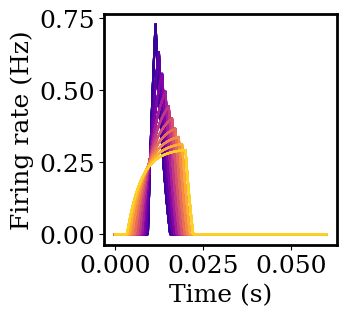

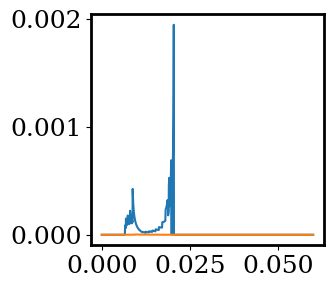

In [344]:
b_fixed = .4
w_set = 0.001
w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 0
b_coef_I2 = 0
# fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, 0, b_rate=0, b=b_fixed, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

a_plot, T_plot = np.meshgrid(np.linspace(2, 20, 10), np.linspace(0.003, 0.02, 10))
fixed_points, valid_solns_mask = find_fixed_point(a_plot, T_plot, w_set, 0, b_rate=0, b=b_fixed, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

T_max_half = T_plot.max() / 2

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

n_lines = 110
cmap = mpl.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

dt = 0.00005
t = np.linspace(0, 0.2, int(0.2 / dt))

all_r_outs_adjusted = []
for i in range(fixed_points.shape[0]):
#     axs.plot(t, 2.5 * i + np.where(np.logical_and(t > 0, t < T_plot.flatten()[i]), a_plot.flatten()[i], 0), '--', c=colors[i], alpha=0.4)
    r_out = comp_r_out(fixed_points[i, 0], b_fixed, a_plot.flatten()[i], T_plot.flatten()[i], t)
#     axs.plot(t, 2.5 * i + r_out, c=colors[i])
    
    r_out_adjust = np.concatenate([np.zeros(int((T_max_half - (T_plot.flatten()[i] / 2)) / dt)), r_out])
#     axs.plot(np.arange(len(r_out_adjust)), 2.5 * i + r_out_adjust, c=colors[i])
    r_out_adjust = r_out_adjust[:int(0.06/dt)]
    all_r_outs_adjusted.append(r_out_adjust)
    axs.plot(np.arange(len(r_out_adjust)) * dt, r_out_adjust, c=colors[i])
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing rate (Hz)')

all_r_outs_adjusted = np.array(all_r_outs_adjusted)
all_r_outs_adjusted = all_r_outs_adjusted / all_r_outs_adjusted.sum(axis=1).reshape(len(a_plot.flatten()), 1)
# axs.plot(np.arange(all_r_outs_adjusted.shape[1]) * dt, np.var(all_r_outs_adjusted, axis=0) * 5 * 10e6)
print(np.var(all_r_outs_adjusted, axis=0).sum())

normed_derivative = np.log(all_r_outs_adjusted[:, 1:]) - np.log(all_r_outs_adjusted[:, :-1])
normed_derivative = np.where(~np.isnan(normed_derivative) & (all_r_outs_adjusted[:, 1:] > 1e-3) & (all_r_outs_adjusted[:, :-1] > 1e-3), normed_derivative, 0)
fisher_info_w_m2 = np.sum(np.square(np.abs(normed_derivative) * all_r_outs_adjusted[:, :-1]), axis=0)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.plot(np.arange(len(fisher_info_dual)) * dt, fisher_info_dual)
axs.plot(np.arange(len(fisher_info_w_m2)) * dt, fisher_info_w_m2)
# axs.set_ylim(0, 0.5e-10)

In [130]:
b_fixed = 0.3
w_set = 0.001
w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 0
b_coef_I2 = 0

a, T = np.meshgrid(np.linspace(2, 20, 100), np.linspace(0.003, 0.02, 100))
fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, 0, b_rate=0, b=b_fixed, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

10000
1.803616211183644e-07 0.013673968723506746


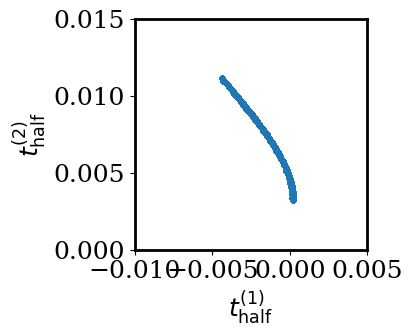

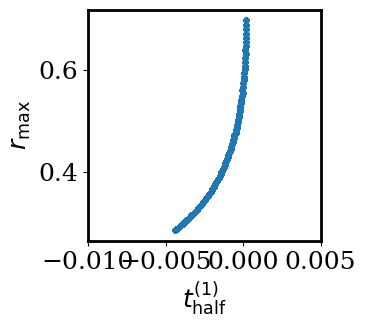

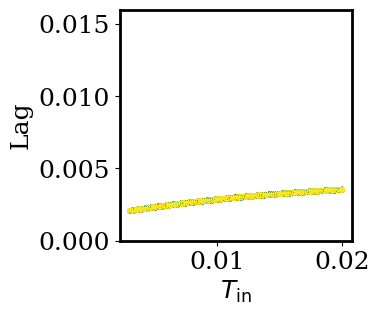

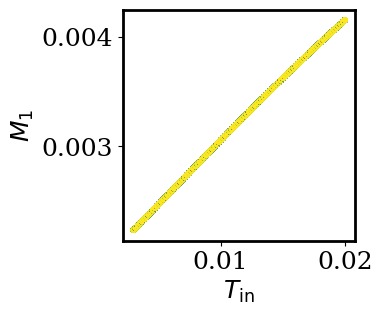

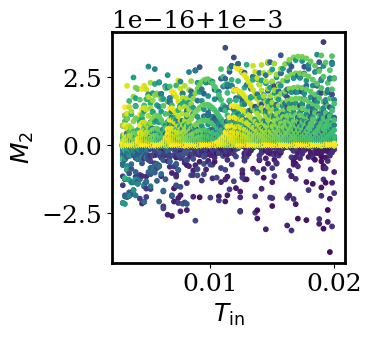

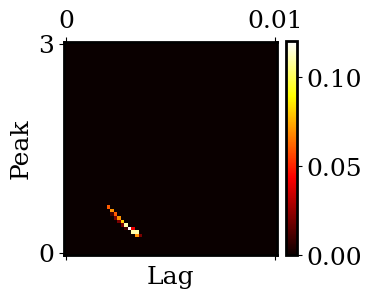

In [131]:
print(np.count_nonzero(valid_solns_mask))

a_valid = a.flatten()[valid_solns_mask]
T_valid = T.flatten()[valid_solns_mask]

I1, I2 = comp_integrals(fixed_points[:, 0], b_fixed, a_valid, T_valid)
lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], b_fixed, a_valid, T_valid)

t_first_half_maxes = np.empty((fixed_points.shape[0]))
t_second_half_maxes = np.empty((fixed_points.shape[0]))

for i in range(fixed_points.shape[0]):
    r_out, t_first_half_max, t_second_half_max = comp_r_out(fixed_points[i, 0], b_fixed, a_valid[i], T_valid[i], t)
    t_first_half_maxes[i] = t_first_half_max - T_valid[i] / 2
    t_second_half_maxes[i] = t_second_half_max - T_valid[i] / 2

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(t_first_half_maxes, t_second_half_maxes, s=10)
axs.set_xlim(-0.01, 0.005)
axs.set_ylim(0, 0.015)
axs.set_xlabel(r'$t_{\rm half}^{(1)}$')
axs.set_ylabel(r'$t_{\rm half}^{(2)}$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(t_first_half_maxes, peaks, s=10)
axs.set_xlim(-0.01, 0.005)
# axs.set_ylim(0, 0.015)
axs.set_xlabel(r'$t_{\rm half}^{(1)}$')
axs.set_ylabel(r'$r_{\rm max}$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(T.flatten()[valid_solns_mask], lags, c=a.flatten()[valid_solns_mask], s=10)
axs.set_ylim(0, 0.016)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'Lag')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T.flatten()[valid_solns_mask], I1, c=a.flatten()[valid_solns_mask], s=10)
lag_max = 0.01
lag_min = 0
I1_max = 0.02
I1_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_1$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(T.flatten()[valid_solns_mask], I2, c=a.flatten()[valid_solns_mask], s=10)
lag_max = 0.01
lag_min = 0
peak_max = 3
peak_min = 0
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_2$')

tiling_size = 60
density = np.zeros((tiling_size, tiling_size))
for lag, peak in zip(lags, peaks):
    i_peak = int((peak - peak_min) / (peak_max - peak_min) * tiling_size)
    i_lag = int((lag - lag_min) / (lag_max - lag_min) * tiling_size)
    density[i_peak, i_lag] += 1
    
density = density / density.sum()

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(density, cmap='hot', origin='lower', vmin=0)
axs.set_xticks([0, tiling_size - 1])
axs.set_xticklabels([lag_min, lag_max])
axs.set_yticks([0, tiling_size - 1])
axs.set_yticklabels([peak_min, peak_max])
fig.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_xlabel('Lag')
axs.set_ylabel(r'Peak')

print(np.var(lags), np.var(peaks))

5.3713236839208156e-05
2.2580881771777022e-08


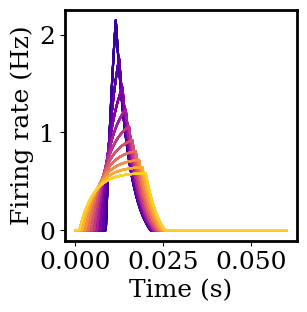

In [457]:
b_fixed = 0.2
w_set = 0.01
w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 0
fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b_rate=0, b=b_fixed, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

a_plot, T_plot = np.meshgrid(np.linspace(2, 20, 10), np.linspace(0.003, 0.02, 10))
fixed_points, valid_solns_mask = find_fixed_point(a_plot, T_plot, w_set, b_set, b_rate=0, b=b_fixed, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

T_max_half = T_plot.max() / 2

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

n_lines = 110
cmap = mpl.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

dt = 0.000025
t = np.linspace(0, 0.06, int(0.06 / dt))

all_r_outs_adjusted = []
for i in range(fixed_points.shape[0]):
#     axs.plot(t, 2.5 * i + np.where(np.logical_and(t > 0, t < T_plot.flatten()[i]), a_plot.flatten()[i], 0), '--', c=colors[i], alpha=0.4)
    r_out = comp_r_out(fixed_points[i, 0], b_fixed, a_plot.flatten()[i], T_plot.flatten()[i], t)
#     axs.plot(t, 2.5 * i + r_out, c=colors[i])
    
    r_out_adjust = np.concatenate([np.zeros(int((T_max_half - (T_plot.flatten()[i] / 2)) / dt)), r_out])
#     axs.plot(np.arange(len(r_out_adjust)), 2.5 * i + r_out_adjust, c=colors[i])
    r_out_adjust = r_out_adjust[:int(0.06/dt)]
    all_r_outs_adjusted.append(r_out_adjust)
    axs.plot(np.arange(len(r_out_adjust)) * dt, r_out_adjust, c=colors[i])
    
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing rate (Hz)')

all_r_outs_adjusted = np.array(all_r_outs_adjusted)
all_r_outs_adjusted = all_r_outs_adjusted / all_r_outs_adjusted.sum()
print(all_r_outs_adjusted.max())
# axs.plot(np.arange(all_r_outs_adjusted.shape[1]) * dt, np.var(all_r_outs_adjusted, axis=0) * 5 * 10e6)
print(np.var(all_r_outs_adjusted, axis=0).sum())

In [65]:
b_fixed = 0.5
w_set = 0.012
w_coef_I1 = 1
w_coef_I2 = 0
b_coef_I1 = 0
b_coef_I2 = 0
fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, b_rate=0, b=b_fixed, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)

10000
5.640793949828744e-08 0.34862089788422407


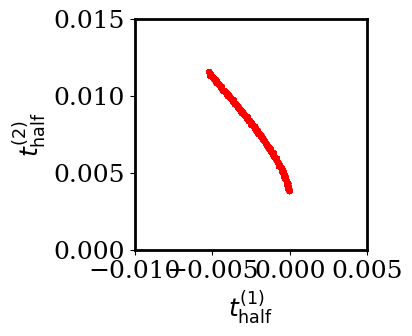

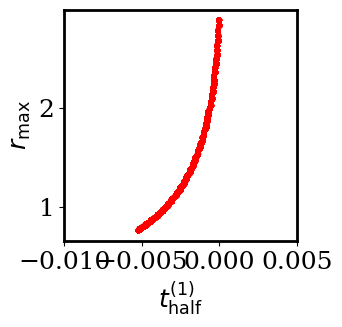

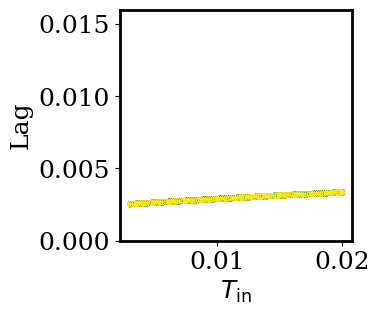

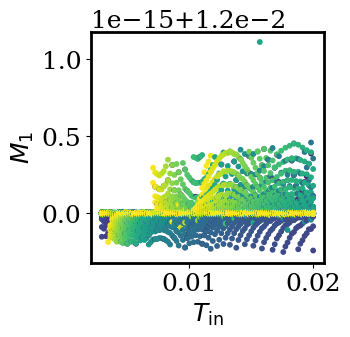

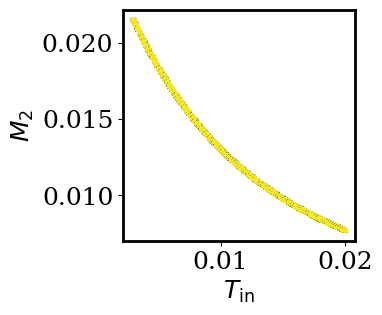

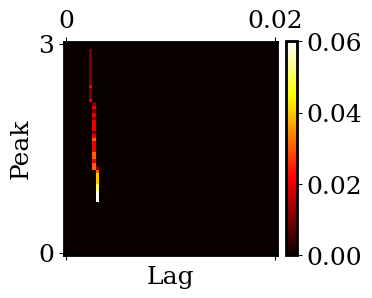

In [66]:
print(np.count_nonzero(valid_solns_mask))

a_valid = a.flatten()[valid_solns_mask]
T_valid = T.flatten()[valid_solns_mask]

I1, I2 = comp_integrals(fixed_points[:, 0], b_fixed, a_valid, T_valid)
lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], b_fixed, a_valid, T_valid)

t_first_half_maxes = np.empty((fixed_points.shape[0]))
t_second_half_maxes = np.empty((fixed_points.shape[0]))

for i in range(fixed_points.shape[0]):
    r_out, t_first_half_max, t_second_half_max = comp_r_out(fixed_points[i, 0], b_fixed, a_valid[i], T_valid[i], t)
    t_first_half_maxes[i] = t_first_half_max - T_valid[i] / 2
    t_second_half_maxes[i] = t_second_half_max - T_valid[i] / 2

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(t_first_half_maxes, t_second_half_maxes, c=stable_colors, s=10)
axs.set_xlim(-0.01, 0.005)
axs.set_ylim(0, 0.015)
axs.set_xlabel(r'$t_{\rm half}^{(1)}$')
axs.set_ylabel(r'$t_{\rm half}^{(2)}$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(t_first_half_maxes, peaks, c=stable_colors, s=10)
axs.set_xlim(-0.01, 0.005)
# axs.set_ylim(0, 0.015)
axs.set_xlabel(r'$t_{\rm half}^{(1)}$')
axs.set_ylabel(r'$r_{\rm max}$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
axs.scatter(T.flatten()[valid_solns_mask], lags, c=a.flatten()[valid_solns_mask], s=10)
axs.set_ylim(0, 0.016)
# axs.set_ylim(0, 2 * w_set)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'Lag')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T.flatten()[valid_solns_mask], I1, c=a.flatten()[valid_solns_mask], s=10)
lag_max = 0.02
lag_min = 0
I1_max = 0.02
I1_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_1$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T.flatten()[valid_solns_mask], I2, c=a.flatten()[valid_solns_mask], s=10)
lag_max = 0.02
lag_min = 0
peak_max = 3
peak_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_2$')

# scale = 1.5
# fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

# axs.scatter(T.flatten()[valid_solns_mask], a.flatten()[valid_solns_mask], c=stable_colors, s=10)
# lag_max = 0.02
# lag_min = 0
# I1_max = 0.02
# I1_min = 0
# # axs.set_ylim(I1_min, I1_max)
# # axs.set_xlim(lag_min, lag_max)
# axs.set_xlabel(r'$T_{\rm in}$')
# axs.set_ylabel(r'$M_1$')

tiling_size = 60
density = np.zeros((tiling_size, tiling_size))
for lag, peak in zip(lags, peaks):
    i_peak = int((peak - peak_min) / (peak_max - peak_min) * tiling_size)
    i_lag = int((lag - lag_min) / (lag_max - lag_min) * tiling_size)
    density[i_peak, i_lag] += 1
    
density = density / density.sum()

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(density, cmap='hot', origin='lower', vmin=0)
axs.set_xticks([0, tiling_size - 1])
axs.set_xticklabels([lag_min, lag_max])
axs.set_yticks([0, tiling_size - 1])
axs.set_yticklabels([peak_min, peak_max])
fig.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_xlabel('Lag')
axs.set_ylabel(r'Peak')

print(np.var(lags), np.var(peaks))

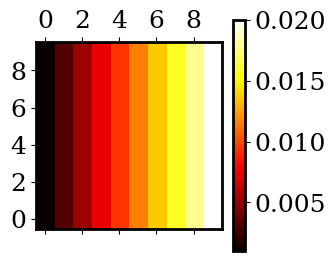

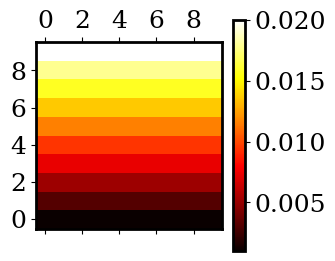

In [415]:
w_set_all, b_set_all = np.meshgrid(np.linspace(0.001, 0.02, 10), np.linspace(0.001, 0.02, 10))

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(w_set_all, cmap='hot', origin='lower')
plt.colorbar(cbar)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(b_set_all, cmap='hot', origin='lower')
plt.colorbar(cbar)

In [93]:
tau_s = 0.004
a, T = np.meshgrid(np.linspace(2, 20, 10), np.linspace(0.003, 0.02, 10))
T_max_half = T.max() / 2

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 1
b_coef_I2 = 0

w_set_all, b_set_all = np.meshgrid(np.linspace(0.001, 0.02, 10), np.linspace(0.001, 0.02, 10))
n_param_pairs = len(w_set_all.flatten())

all_peak_vars = []
all_t_vars = []
valid_soln_counts = []
total_fisher_infos = []

peak_means = np.zeros((n_param_pairs))
peak_vars = np.zeros((n_param_pairs))
t_half_max_1_means = np.zeros((n_param_pairs))
t_half_max_1_vars = np.zeros((n_param_pairs))
t_half_max_2_means = np.zeros((n_param_pairs))
t_half_max_2_vars = np.zeros((n_param_pairs))

for param_pair_idx, (w_set, b_set) in enumerate(zip(w_set_all.flatten(), b_set_all.flatten())):
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, b_set, w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
    solns_count = np.count_nonzero(valid_solns_mask)
    valid_soln_counts.append(solns_count)
    
    if solns_count == 0:
        all_vars.append(np.nan)
    else:
        if len(fixed_points.shape) == 1:
            fixed_points = fixed_points.reshape(1, 2)
            
        dt = 0.00005
        t = np.linspace(0, 0.2, int(0.2 / dt))

        all_r_outs_adjusted = []
        t_means = []
        peaks = np.zeros((fixed_points.shape[0]))
        
        for i in range(fixed_points.shape[0]):
        #     axs.plot(t, 2.5 * i + np.where(np.logical_and(t > 0, t < T_plot.flatten()[i]), a_plot.flatten()[i], 0), '--', c=colors[i], alpha=0.4)
            r_out, t_first_half_max, t_second_half_max = comp_r_out(fixed_points[i, 0], fixed_points[i, 1], a.flatten()[valid_solns_mask][i], T.flatten()[valid_solns_mask][i], t)
            
            peaks[i] = r_out.max()
            t_first_half_maxes[i] = t_first_half_max - T_valid[i] / 2
            t_second_half_maxes[i] = t_second_half_max - T_valid[i] / 2
            
            r_out_normed = r_out / np.sum(r_out)
            t_mean = np.sum(r_out_normed * t) - (T.flatten()[valid_solns_mask][i] / 2)
            t_means.append(t_mean)
            if not np.isclose(r_out[-1], 0):
                print(r_out[-1])
            r_out_adjust = np.concatenate([np.zeros(int((T_max_half - (T.flatten()[valid_solns_mask][i] / 2)) / dt)), r_out])
            r_out_adjust = r_out_adjust[:int(0.2/dt)]
            all_r_outs_adjusted.append(r_out_adjust)
            
        peak_means[param_pair_idx] = peaks.mean()
        peak_vars[param_pair_idx] = peaks.var()
        t_half_max_1_means[param_pair_idx] = t_first_half_maxes.mean()
        t_half_max_1_vars[param_pair_idx] = t_first_half_maxes.var()
        t_half_max_2_means[param_pair_idx] = t_second_half_maxes.mean()
        t_half_max_2_vars[param_pair_idx] = t_second_half_maxes.var()
        
        all_r_outs_adjusted = np.array(all_r_outs_adjusted)
        all_r_outs_adjusted = all_r_outs_adjusted / all_r_outs_adjusted.sum(axis=1).reshape(len(a.flatten()), 1)
        normed_derivative = np.log(all_r_outs_adjusted[:, 1:]) - np.log(all_r_outs_adjusted[:, :-1])
        normed_derivative = np.where(~np.isnan(normed_derivative) & (all_r_outs_adjusted[:, 1:] > 1e-3) & (all_r_outs_adjusted[:, :-1] > 1e-3), normed_derivative, 0)
        fisher_info = np.sum(np.square(np.abs(normed_derivative)) * all_r_outs_adjusted[:, :-1], axis=0)
        if fixed_points.shape[0] != len(a.flatten()):
            total_fisher_infos.append(0)
        else:    
            total_fisher_infos.append(np.sum(np.sqrt(fisher_info)))
        all_peak_vars.append(np.var(peaks / np.mean(peaks)))
        all_t_vars.append(np.var(t_means))
    
av = np.array(all_peak_vars).reshape(10, 10)
vcn = np.array(valid_soln_counts).reshape(10, 10)
all_t_vars = np.array(all_t_vars).reshape(10, 10)
total_fisher_infos = np.array(total_fisher_infos).reshape(10, 10)

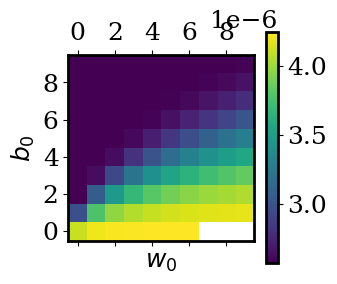

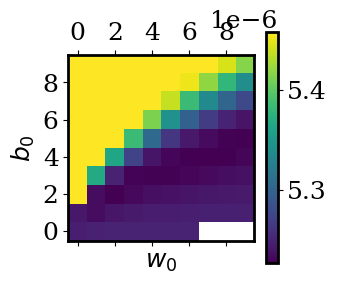

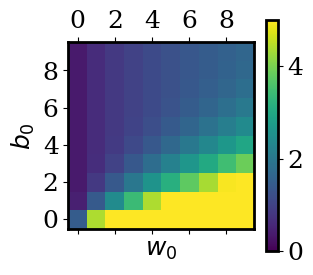

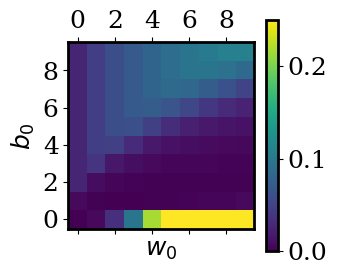

In [113]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(t_half_max_1_vars.reshape(w_set_all.shape), origin='lower')
# axs.errorbar(t_half_max_1_means, t_half_max_2_means, xerr=t_half_max_1_vars, yerr=t_half_max_2_vars, ls='none')
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
plt.colorbar(cbar)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(t_half_max_2_vars.reshape(w_set_all.shape), origin='lower')
# axs.errorbar(t_half_max_1_means, t_half_max_2_means, xerr=t_half_max_1_vars, yerr=t_half_max_2_vars, ls='none')
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
plt.colorbar(cbar)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow((peak_means).reshape(w_set_all.shape), vmin=0, vmax=5, origin='lower')
# axs.errorbar(t_half_max_1_means, t_half_max_2_means, xerr=t_half_max_1_vars, yerr=t_half_max_2_vars, ls='none')
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
plt.colorbar(cbar)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow((peak_vars / peak_means).reshape(w_set_all.shape), origin='lower', vmin=0, vmax=0.25)
# axs.errorbar(t_half_max_1_means, t_half_max_2_means, xerr=t_half_max_1_vars, yerr=t_half_max_2_vars, ls='none')
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
plt.colorbar(cbar)

NameError: name 'av' is not defined

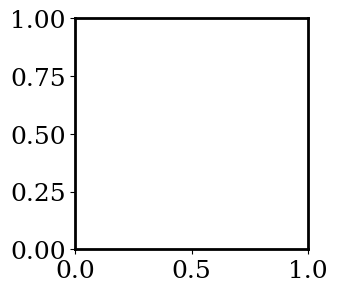

In [68]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(av, cmap='hot', origin='lower', vmin=0, vmax=0.1)
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
plt.colorbar(cbar)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(all_t_vars, cmap='hot', origin='lower', vmin=0, vmax=1e-6)
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
plt.colorbar(cbar)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(vcn, cmap='hot', origin='lower', vmin=0, vmax=100)
plt.colorbar(cbar)


In [324]:
tau_s = 0.004
a, T = np.meshgrid(np.linspace(2, 20, 10), np.linspace(0.003, 0.02, 10))
T_max_half = T.max() / 2

w_set_all, b_fixed_all = np.meshgrid(np.linspace(0.001, 0.02, 10), np.linspace(0.001, 1, 10))

w_coef_I1 = 0
w_coef_I2 = 1
b_coef_I1 = 0
b_coef_I2 = 0

all_peak_vars = []
all_t_vars = []
valid_soln_counts = []
total_fisher_infos = []

for w_set, b_fixed in zip(w_set_all.flatten(), b_fixed_all.flatten()):
    fixed_points, valid_solns_mask = find_fixed_point(a, T, w_set, 0, b_rate=0, b=b_fixed,
                                    w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
    solns_count = np.count_nonzero(valid_solns_mask)
    valid_soln_counts.append(solns_count)
        
    if solns_count == 0:
        all_vars.append(np.nan)
    else:
        if len(fixed_points.shape) == 1:
            fixed_points = fixed_points.reshape(1, 2)
        dt = 0.00005
        t = np.linspace(0, 0.2, int(0.2 / dt))
        
        all_r_outs_adjusted = []
        t_means = []
        peaks = np.empty((fixed_points.shape[0]))
        t_first_half_maxes = np.empty((fixed_points.shape[0]))
        t_second_half_maxes = np.empty((fixed_points.shape[0]))
        
        for i in range(fixed_points.shape[0]):
        #     axs.plot(t, 2.5 * i + np.where(np.logical_and(t > 0, t < T_plot.flatten()[i]), a_plot.flatten()[i], 0), '--', c=colors[i], alpha=0.4)
            r_out = comp_r_out(fixed_points[i, 0], b_fixed, a.flatten()[valid_solns_mask][i], T.flatten()[valid_solns_mask][i], t)
            peaks[i] = r_out.max()
            t_first_half_maxes[i] = t_first_half_max - T_valid[i] / 2
            t_second_half_maxes[i] = t_second_half_max - T_valid[i] / 2
            r_out_normed = r_out / np.sum(r_out)
            t_mean = np.sum(r_out_normed * t) - (T.flatten()[valid_solns_mask][i] / 2)
            t_means.append(t_mean)
            if not np.isclose(r_out[-1], 0):
                print(r_out[-1])
            r_out_adjust = np.concatenate([np.zeros(int((T_max_half - (T.flatten()[valid_solns_mask][i] / 2)) / dt)), r_out])
            r_out_adjust = r_out_adjust[:int(0.2/dt)]
            all_r_outs_adjusted.append(r_out_adjust)
            
        all_r_outs_adjusted = np.array(all_r_outs_adjusted)
        all_r_outs_adjusted = all_r_outs_adjusted / all_r_outs_adjusted.sum(axis=1).reshape(all_r_outs_adjusted.shape[0], 1)
        normed_derivative = np.log(all_r_outs_adjusted[:, 1:]) - np.log(all_r_outs_adjusted[:, :-1])
        normed_derivative = np.where(~np.isnan(normed_derivative) & (all_r_outs_adjusted[:, 1:] > 1e-3) & (all_r_outs_adjusted[:, :-1] > 1e-3), normed_derivative, 0)
        fisher_info = np.sum(np.square(np.abs(normed_derivative)) * all_r_outs_adjusted[:, :-1], axis=0)
        if fixed_points.shape[0] != len(a.flatten()):
            total_fisher_infos.append(0)
        else:    
            total_fisher_infos.append(np.sum(np.sqrt(fisher_info)))
        all_peak_vars.append(np.var(peaks / np.mean(peaks)))
        all_t_vars.append(np.var(t_means))
    
av_2 = np.array(all_peak_vars).reshape(10, 10)
vcn_2 = np.array(valid_soln_counts).reshape(10, 10)
all_t_vars_2 = np.array(all_t_vars).reshape(10, 10)
total_fisher_infos_2 = np.array(total_fisher_infos).reshape(10, 10)

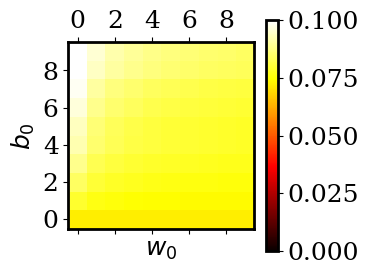

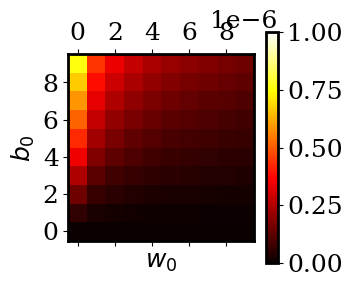

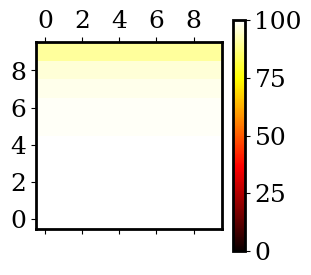

In [325]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(av_2, cmap='hot', origin='lower', vmin=0, vmax=0.1)
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
plt.colorbar(cbar)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(all_t_vars_2, cmap='hot', origin='lower', vmin=0, vmax=1e-6)
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
plt.colorbar(cbar)

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(vcn_2, cmap='hot', origin='lower', vmin=0, vmax=100)
plt.colorbar(cbar)

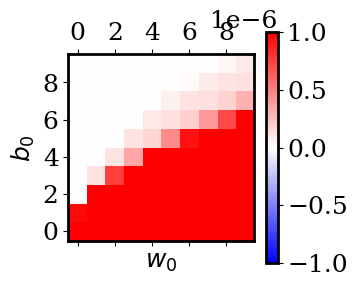

In [331]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
diffs = (all_t_vars - np.repeat(all_t_vars_2[0, :], 10).reshape(10, 10))
m = np.abs(diffs).max()
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
cbar = axs.matshow(diffs, cmap='bwr', origin='lower', vmax=1e-6, vmin=-1e-6)
plt.colorbar(cbar)

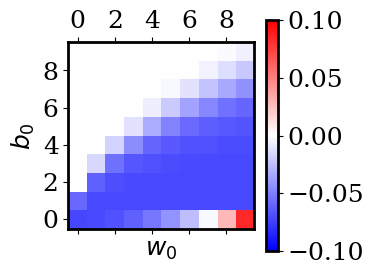

In [334]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
diffs = (av - np.repeat(av_2[0, :], 10).reshape(10, 10))
m = np.abs(diffs).max()
axs.set_xlabel(r'$w_{0}$')
axs.set_ylabel(r'$b_{0}$')
cbar = axs.matshow(diffs, cmap='bwr', origin='lower', vmax=0.1, vmin=-0.1)
plt.colorbar(cbar)

Really only need to think about 4 kinds of inputs:
1. Short time scale, low amp
2. Short time scale, high amp
3. Long time scale, low amp
4. Long time scale, high amp

Try to get some intuition for what each set of rules does for each.

[854.91006306  58.38799386]
[963.49287431  67.09789921]
[1271.80183783   93.21864018]


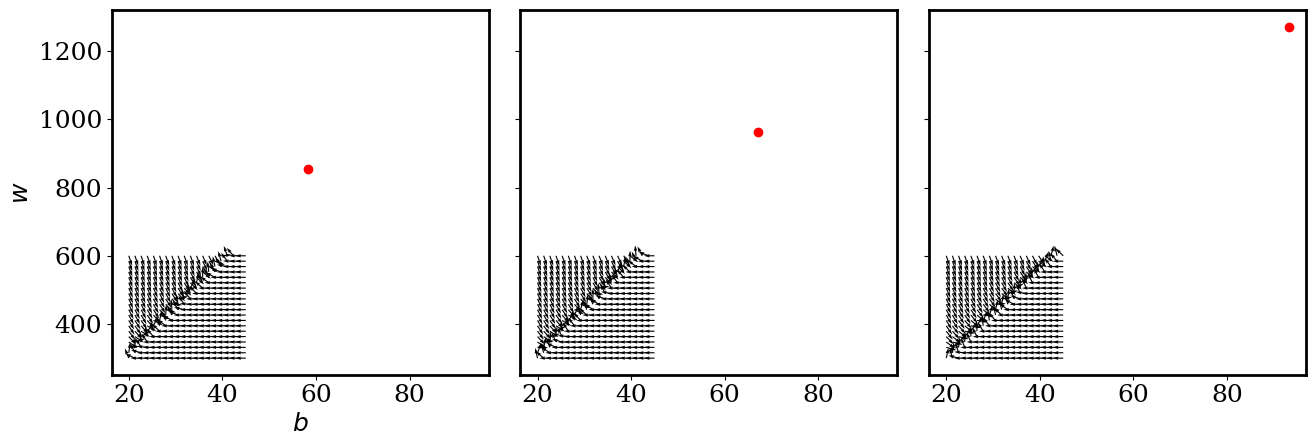

In [132]:
tau_s = 0.004
tau_l = 0.006
t_comb_inv = (1 / tau_s + 1 / tau_l)
w_set = 0
b_set = 0.01

scale = 1.5
fig, axs = plt.subplots(1, 3, figsize=(9 * scale, 3.2 * scale), sharex=True, sharey=True)
w, b = np.meshgrid(np.linspace(300, 600, 20), np.linspace(20, 45, 20))

# panel 1
T = np.array([0.0095])
a = np.array([20])

delta_w, delta_b = comp_changes_stdp(w, b, a, T, w_set, b_set, 0.25, 50, 10000)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[0].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point_stdp(a, T, w_set, b_set, stdp_rate=10000)
fixed_point = fixed_points[0]
print(fixed_point)
axs[0].scatter(fixed_point[1], fixed_point[0], color='red')
axs[0].set_ylabel(r'$w$')
axs[0].set_xlabel(r'$b$')

# derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0],
#                           w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
# derivs_mat = np.array([[derivs[0], derivs[1]], [derivs[2], derivs[3]]])
# print(np.linalg.eig(derivs_mat))

# panel 2
T = np.array([0.010])
a = np.array([20])

delta_w, delta_b = comp_changes_stdp(w, b, a, T, w_set, b_set, 0.25, 50, 10000)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[1].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point_stdp(a, T, w_set, b_set, stdp_rate=10000)
fixed_point = fixed_points[0]
print(fixed_point)
axs[1].scatter(fixed_point[1], fixed_point[0], color='red')

# derivs = comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0],
#                           w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
# derivs = np.array([[derivs[0], derivs[1]], [derivs[2], derivs[3]]])
# print(np.linalg.eig(derivs))

# panel 3
T = np.array([0.012])
a = np.array([20])

delta_w, delta_b = comp_changes_stdp(w, b, a, T, w_set, b_set, 0.25, 50, 10000)
norms = np.sqrt(np.square(delta_w) + np.square(delta_b))

axs[2].quiver(b, w, delta_b / norms, delta_w / norms, color='black')

fixed_points, valid_solns_mask = find_fixed_point_stdp(a, T, w_set, b_set, stdp_rate=10000)
fixed_point = fixed_points[0]
print(fixed_point)
axs[2].scatter(fixed_point[1], fixed_point[0], color='red')

# print(comp_derivatives(np.array(fixed_point[0]), np.array(fixed_point[1]), a[0], T[0]))

fig.tight_layout()

In [147]:
tau_s = 0.004
tau_l = 0.006
t_comb_inv = (1 / tau_s + 1 / tau_l)
w_set = 0.1
b_set = 0.01
stdp_rate = 10000

a, T = np.meshgrid(np.linspace(2, 20, 100), np.linspace(0.003, 0.02, 100))

fixed_points, valid_solns_mask = find_fixed_point_stdp(a, T, w_set, b_set, stdp_rate=stdp_rate)
np.count_nonzero(valid_solns_mask)

6218

6217
[1583.54483079  123.71308257]
1.8978805639472157e-06 0.3932591771813407


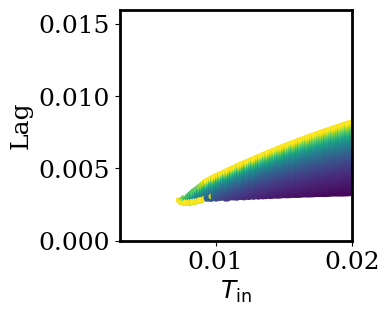

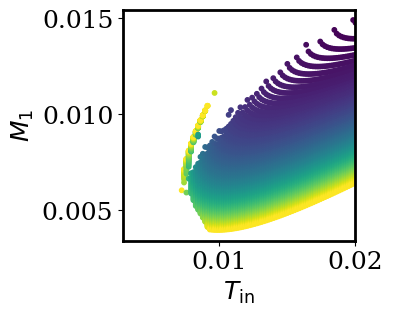

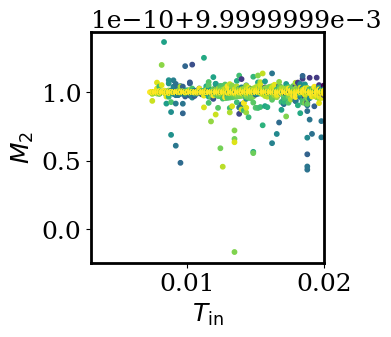

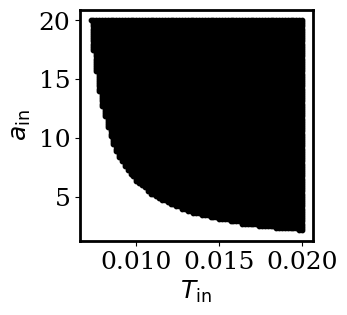

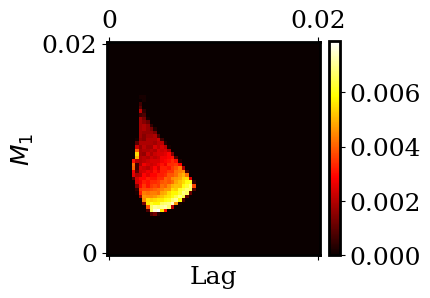

In [148]:
I1, I2 = comp_integrals(fixed_points[:, 0], fixed_points[:, 1], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])
lags, peaks = comp_lags_and_peaks(fixed_points[:, 0], fixed_points[:, 1], a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask])   
print(lags.argmax())

# derivs = comp_derivatives(np.array(fixed_points[:, 0]), np.array(fixed_points[:, 1]), a.flatten()[valid_solns_mask], T.flatten()[valid_solns_mask],
#                           w_coef_I1=w_coef_I1, w_coef_I2=w_coef_I2, b_coef_I1=b_coef_I1, b_coef_I2=b_coef_I2)
# derivs = np.array(derivs)
# derivs = derivs.reshape(2, 2, derivs.shape[1])

# stable_count = 0
# stable = np.zeros(fixed_points.shape[0])

# for k in range(derivs.shape[-1]):
#     derivs_k = derivs[..., k]
#     if not np.isnan(derivs_k).any():
#         eigen_vals = np.linalg.eig(derivs[..., k])[0]
#         if (eigen_vals < 0).all() and not np.isclose(eigen_vals, 0).any():
#             stable_count += 1
#             stable[k] = 1

# print('stable_count', stable_count)
# stable_colors = ['blue' if i == 1 else 'red' for i in stable]

# derivs = np.array([[-derivs[0], -derivs[1]], [derivs[2], derivs[3]]])
# print(np.linalg.eig(derivs))



print(fixed_points[lags.argmax(), :])

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T.flatten()[valid_solns_mask], lags, c=a.flatten()[valid_solns_mask], s=10)
axs.set_ylim(0, 0.016)
axs.set_xlim(T.min(), T.max())
# axs.set_ylim(0, 2 * w_set)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'Lag')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T.flatten()[valid_solns_mask], I1, c=a.flatten()[valid_solns_mask], s=10)
axs.set_xlim(T.min(), T.max())
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_1$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T.flatten()[valid_solns_mask], I2, c=a.flatten()[valid_solns_mask], s=10)
axs.set_xlim(T.min(), T.max())
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$M_2$')

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))

axs.scatter(T.flatten()[valid_solns_mask], a.flatten()[valid_solns_mask], c='black', s=10)
lag_max = 0.02
lag_min = 0
I1_max = 0.02
I1_min = 0
# axs.set_ylim(I1_min, I1_max)
# axs.set_xlim(lag_min, lag_max)
axs.set_xlabel(r'$T_{\rm in}$')
axs.set_ylabel(r'$a_{\rm in}$')

tiling_size = 60
density = np.zeros((tiling_size, tiling_size))
for lag, i1 in zip(lags, I1):
    i_I1 = int((i1 - I1_min) / (I1_max - I1_min) * tiling_size)
    i_lag = int((lag - lag_min) / (lag_max - lag_min) * tiling_size)
    density[i_I1, i_lag] += 1
    
density = density / density.sum()

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
cbar = axs.matshow(density, cmap='hot', origin='lower', vmin=0)
axs.set_xticks([0, tiling_size - 1])
axs.set_xticklabels([lag_min, lag_max])
axs.set_yticks([0, tiling_size - 1])
axs.set_yticklabels([I1_min, I1_max])
fig.colorbar(cbar, fraction=0.046, pad=0.04)
axs.set_xlabel('Lag')
axs.set_ylabel(r'$M_1$')

print(np.var(lags), np.var(peaks))